In [1]:
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.table import Table
from astropy.io import fits
from astropy.wcs import WCS
from astropy.modeling.functional_models import Sersic2D, Gaussian2D
from reproject import reproject_interp
from astropy.cosmology import FlatLambdaCDM
from pylab import contour, savefig
from astropy.convolution import convolve, Gaussian2DKernel
from astropy.visualization import LogStretch, ImageNormalize, SquaredStretch, ManualInterval, PowerStretch
import math
import emcee
from scipy.optimize import minimize
import scipy.special as sp
from scipy import integrate
from scipy.interpolate import interp2d
from scipy.stats import mode
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
from importlib import reload
import corner
import KnotFitClass as kf
from IPython.display import display, Math

In [2]:
indir = 'whl0137'
imfile = 'hlsp_relics_hst_wfc3ir-60mas_whl0137-08_f110w_drz.fits' 
imfile = os.path.join(indir,imfile)

modeldir = 'whl0137/lens_modelling/zitrin/TosendBrianWithMinimization/models/imv2_125only/final_f012_5kstep'
dflx = os.path.join(modeldir, 'alpha_x_whl0137_6p2_20210206_LTM_Gc_2HST.fits')
dfly = os.path.join(modeldir, 'alpha_y_whl0137_6p2_20210206_LTM_Gc_2HST.fits')
magnif = os.path.join(modeldir, 'magnif-inv_whl0137_6p2_20210206_LTM_Gc.fits')
#dflx = os.path.join(modeldir, 'alpha_x_whl0137_6p2_20210206_LTM_Gc.fits')
#dfly = os.path.join(modeldir, 'alpha_y_whl0137_6p2_20210206_LTM_Gc.fits')

#modeldir = 'whl0137/lens_modelling/lenstool/ModelQ/best'
#dflx = os.path.join(modeldir, 'dx_z6p2_2HST.fits')
#dfly = os.path.join(modeldir, 'dy_z6p2_2HST.fits')
#magnif = os.path.join(modeldir, 'magnif-inv_z6p2.fits')
#modeldir = 'whl0137/lens_modelling/lenstool/ModelQ/low_ellip'
#dflx = os.path.join(modeldir, 'dx_z6_test.fits')
#dfly = os.path.join(modeldir, 'dy_z6_test.fits')

#modeldir = 'whl0137/lens_modelling/wslap'
#dflx = os.path.join(modeldir, 'AlphaX_Z_arcsec_ModelIIc.fits')
#dfly = os.path.join(modeldir, 'AlphaY_Z_arcsec_ModelIIc.fits')
#magnif = os.path.join(modeldir, 'magnif-inv_Z_arcsec_ModelIIc.fits')

#modeldir = 'whl0137/lens_modelling/glafic/'
#dflx = os.path.join(modeldir, 'hlsp_relics_model_model_whl0137-08_glafic_v2_x-arcsec-deflectz6p2_2HST.fits')
#dfly = os.path.join(modeldir, 'hlsp_relics_model_model_whl0137-08_glafic_v2_y-arcsec-deflectz6p2_2HST.fits')
#dflx = os.path.join(modeldir, 'c_1/hlsp_relics_model_model_whl0137-08_glafic_v3_x-arcsec-deflect.fits')
#dfly = os.path.join(modeldir, 'c_1/hlsp_relics_model_model_whl0137-08_glafic_v3_y-arcsec-deflect.fits')
#magnif = os.path.join(modeldir, 'hlsp_relics_model_model_whl0137-08_glafic_v2_magnif-inv.fits')

In [3]:
# maybe put these helper functions (and make_magnification_map function) in a helper class later?

def Dds_Ds(zl, zs):
    cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
    Dds = cosmo.angular_diameter_distance_z1z2(zl, zs)
    Ds  = cosmo.angular_diameter_distance_z1z2(0 , zs)
    return Dds / Ds


def ddy(A):
    """Numerical derivative: 2nd-order
    output array will have dimentions (N-2, N-2)"""
    dAdy1 = (A[2:] - A[:-2]) / 2.
    dAdy2 = (-A[4:] + 8*A[3:-1] - 8*A[1:-3] + A[:-4]) / 12.
    dAdy1[1:-1,:] = dAdy2
    dAdy1 = dAdy1[:,1:-1]
    return dAdy1

def ddx(A):
    dAdx = ddy(A.T).T
    return dAdx

# Results have dimensions (N-2, N-2)
# Add zero padding to restore to (N, N) HST image pixel grid
def zeropad(data):
    ny, nx = data.shape
    padded = np.zeros((ny+2, nx+2))
    padded[1:-1,1:-1] = data
    return padded

def pix_to_pc(rpix, z):
    cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
    DA = cosmo.angular_diameter_distance_z1z2(0 , z).value * 10**6 #returns in pc
    pixSize = 0.06 #HST WFC3 pixel size
    theta = rpix * pixSize #arcsec
    theta = theta / ((180. / np.pi) * 3600) #radian
    r_pc = theta * DA #phys
    return r_pc

def deltafunc(xx,yy,x,y,amp=1):
    result = np.zeros(xx.shape)
    result[(xx==x) & (yy==y)] = amp
    return result

In [4]:
imhdu = fits.open(imfile)
imdata = imhdu[0].data

In [5]:
reproject = False

if reproject:
    hdudeflx = fits.open(dflx)
    hdudefly = fits.open(dfly)
    #reproject deflection fields to HST WCS pixels
    deflxHST, footprint = reproject_interp(hdudeflx[0], imhdu[0].header)
    deflyHST, footprint = reproject_interp(hdudefly[0], imhdu[0].header)

    # commented out transform for LTM models, which return in pixels already
    ax = deflxHST / 0.06 # arcsec -> pixels
    ay = deflyHST / 0.06 # arcsec -> pixels
    
    # rescale to appropriate redshift
    zsource_in = 0.
    zsource_out = 6.2
    zlens = 0.566

    if zsource_in == 0.: #if already scaled to Dls/Ds = 0
        Dds_Ds_out = Dds_Ds(zlens, zsource_out)

        ax = ax * Dds_Ds_out
        ay = ay * Dds_Ds_out
    elif zsource_in == zsource_out: # if no transformation required
        pass
    else: # if scaled to some redshift
        Dds_Ds_in  = Dds_Ds(zlens, zsource_in)
        Dds_Ds_out = Dds_Ds(zlens, zsource_out)

        ax = ax / Dds_Ds_in * Dds_Ds_out
        ay = ay / Dds_Ds_in * Dds_Ds_out
else:
    ax = fits.open(dflx)[0].data
    ay = fits.open(dfly)[0].data

In [6]:
if reproject:
    axx = ddx(ax)
    ayy = ddy(ay)
    
    axy = ddy(ax)
    ayx = ddx(ay)
    
    kappa  = 0.5 * (axx + ayy)
    gamma1 = 0.5 * (axx - ayy)
    gamma2 = axy
    gamma  = np.sqrt(gamma1**2 + gamma2**2)
    
    kappa = zeropad(kappa)
    gamma = zeropad(gamma)
    
    magnifinv = (1-kappa)**2 - gamma**2

    # save to file?
    outfile = None
    if outfile:
        magnif = 1. / magnifinv
        hdumag = fits.PrimaryHDU(magnif)
        hdumag.header = imhdu[0].header
        hdumag.writeto(outfile)
else:
    magnifinv = fits.open(magnif)[0].data

In [7]:
if 0:
    hdu_dx = fits.PrimaryHDU(ax.value)
    hdu_dx.header = imhdu[0].header
    hdu_dx.writeto(os.path.join(modeldir, 'hlsp_relics_model_model_whl0137-08_glafic_v3_x-arcsec-deflectz6p2_2HST.fits'), overwrite=True)

    hdu_dy = fits.PrimaryHDU(ay.value)
    hdu_dy.header = imhdu[0].header
    hdu_dy.writeto(os.path.join(modeldir, 'hlsp_relics_model_model_whl0137-08_glafic_v3_y-arcsec-deflectz6p2_2HST.fits'))

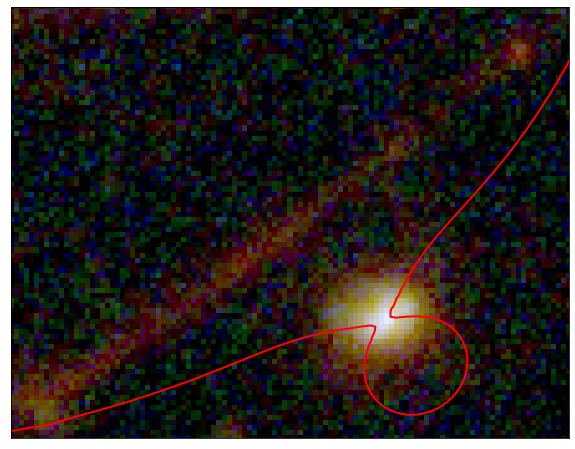

In [7]:
Image.MAX_IMAGE_PIXELS = None
infile = 'whl0137-08_new_bright.png'
infile = os.path.join(indir, infile)
im = Image.open(infile)
im = im.transpose(Image.FLIP_TOP_BOTTOM)

# Define coordinate grid
yy, xx = np.indices(magnifinv.shape)

plt.figure(figsize=(10, 10))
plt.imshow(im, origin='lower')
#xlo, xhi = 1800, 3200 # full cluster
#ylo, yhi = 1700, 3000
#xlo, xhi = 2750, 3100 # full arc
#ylo, yhi = 1800, 2100
xlo, xhi = 2850, 2960 # center image
ylo, yhi = 1900, 1985
#xlo, xhi = 2940, 2960 # center bright knot zoom
#ylo, yhi = 1965, 1985
#xlo, xhi = 2975, 3005 # NW image
#ylo, yhi = 2000, 2035
plt.xlim(xlo, xhi)
plt.ylim(ylo, yhi)
plt.xticks([])
plt.yticks([])
con = plt.contour(xx, yy, magnifinv, [0], colors='r', linewidths=2)
#plt.savefig('whl0137/starpaper/plots/pings/sunrisearc_unlabeled.pdf')

In [8]:
imhdu[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 5000                                                  
NAXIS2  =                 5000                                                  
EXTEND  =                    T                                                  
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
FILENAME= 'hlsp_relics_hst_wfc3ir-60mas_whl0137-08_f110w_drz_sci.fits' / name of
FILETYPE= 'SCI      '          / type of data found in data file                
                                                                                
TELESCOP= 'HST'                / telescope used to acquire data                 
INSTRUME= 'WFC3  '          

In [8]:
# Source position grid
xss = xx - ax
yss = yy - ay

In [9]:
reload(kf)
# define galaxy model for NW image
model = kf.GalModel()

x1, y1 = 2981-1, 2006 # knot 1
xs1 = x1 - ax[y1, x1]
ys1 = y1 - ay[y1, x1]
clump1 = kf.Clump(x0=xs1, y0=ys1, profile="Gaussian")
clump1.set_prior(amin=0, amax=500000, rmin=0.004, rmax=10)
#clump1.fixed = True
model.add_clump(clump1)

x2, y2 = 2994, 2022 # diffuse 1
xs2 = x2 - ax[y2, x2]
ys2 = y2 - ay[y2, x2]
clump2 = kf.Clump(x0=xs2, y0=ys2, profile="Gaussian")
clump2.set_prior(amin=0, amax=500000, rmin=0, rmax=500)
#clump2.fixed = True
model.add_clump(clump2)


x3, y3 = 2991, 2017 # diffuse 2
xs3 = x3 - ax[y3, x3]
ys3 = y3 - ay[y3, x3]
clump3 = kf.Clump(x0=xs3, y0=ys3, profile="Gaussian")
clump3.set_prior(amin=0, amax=500000, rmin=0.004, rmax=50)
model.add_clump(clump3)



In [9]:
reload(kf)
# define galaxy model for center image
model = kf.GalModel()


## middle segment
x1, y1 = 2950, 1976 # knot 1
xs1 = x1 - ax[y1, x1]
ys1 = y1 - ay[y1, x1]
clump1 = kf.Clump(x0=xs1, y0=ys1, profile="Gaussian")
clump1.set_prior(amin=0, amax=500000, rmin=0.004, rmax=10)
#clump1.fixed = True
model.add_clump(clump1)

x2, y2 = 2897, 1935 # diffuse
xs2 = x2 - ax[y2, x2]
ys2 = y2 - ay[y2, x2]
clump2 = kf.Clump(x0=xs2, y0=ys2, profile="Gaussian")
clump2.set_prior(amin=0, amax=500000, rmin=0, rmax=500)
#clump2.fixed = True
model.add_clump(clump2)

x2, y2 = 2897, 1935 # knot 4, center
clump2a = kf.Clump(x0=xs2, y0=ys2, profile="Gaussian")
clump2a.set_prior(amin=0, amax=5000000, rmin=0.004, rmax=10)
model.add_clump(clump2a)

x3, y3 = 2926, 1957 # knot 2
xs3 = x3 - ax[y3, x3]
ys3 = y3 - ay[y3, x3]
clump3 = kf.Clump(x0=xs3, y0=ys3, profile="Gaussian")
clump3.set_prior(amin=0, amax=500000, rmin=0.004, rmax=50)
model.add_clump(clump3)

x4, y4 = 2905, 1941 # knot3, near center
xs4 = x4 - ax[y4, x4]
ys4 = y4 - ay[y4, x4]
clump4 = kf.Clump(x0=xs4, y0=ys4, profile="Gaussian")
clump4.set_prior(amin=0, amax=500000, rmin=0.004, rmax=50)
model.add_clump(clump4)

## additional middle knots
x5, y5 = 2874, 1920 #long z6 knot 5
xs5 = x5 - ax[y5, x5]
ys5 = y5 - ay[y5, x5]
clump5 = kf.Clump(x0=xs5, y0=ys5, profile="Gaussian")
clump5.set_prior(amin=0, amax=500000, rmin=0.004, rmax=50)
model.add_clump(clump5)

x6, y6 = 2870, 1917 #long z6 knot 6
xs6 = x6 - ax[y6, x6]
ys6 = y6 - ay[y6, x6]
clump6 = kf.Clump(x0=xs6, y0=ys6, profile="Gaussian")
clump6.set_prior(amin=0, amax=500000, rmin=0.004, rmax=50)
model.add_clump(clump6)

x7, y7 = 2862, 1912 #long z6 knot 7 
xs7 = x7 - ax[y7, x7]
ys7 = y7 - ay[y7, x7]
clump7 = kf.Clump(x0=xs7, y0=ys7, profile="Gaussian")
clump7.set_prior(amin=0, amax=500000, rmin=0.004, rmax=50)
model.add_clump(clump7)


In [14]:
axx = ddx(ax)
ayy = ddy(ay)
    
axy = ddy(ax)
ayx = ddx(ay)
    
kappa  = 0.5 * (axx + ayy)
gamma1 = 0.5 * (axx - ayy)
gamma2 = axy
gamma  = np.sqrt(gamma1**2 + gamma2**2)
    
kappa = zeropad(kappa)
gamma = zeropad(gamma)
    
inv_mu_tan = 1. - kappa - gamma
mu_tan = 1. / inv_mu_tan

def demag_mu_tan(im_radius_arcsec, mu_tan):
    mu_tan = np.abs(mu_tan)
    source_radius_arcsec = im_radius_arcsec / mu_tan
    kpc_per_arcsec = 5.6 # from ned wright's calculator
    source_radius_kpc = kpc_per_arcsec * source_radius_arcsec
    return source_radius_kpc * 1000.

print(mu_tan[y1, x1], demag_mu_tan(0.1,mu_tan[y1,x1]))
print(mu_tan[y2, x2], demag_mu_tan(0.1,mu_tan[y2,x2]))
print(mu_tan[y3, x3], demag_mu_tan(0.1,mu_tan[y3,x3]))
print(mu_tan[y4, x4], demag_mu_tan(0.1,mu_tan[y4,x4]))
print(mu_tan[y5, x5], demag_mu_tan(0.1,mu_tan[y5,x5]))
print(mu_tan[y6, x6], demag_mu_tan(0.1,mu_tan[y6,x6]))
print(mu_tan[y7, x7], demag_mu_tan(0.1,mu_tan[y7,x7]))


-128.6535545117409 4.35277518856966
-47.196205812540214 11.865360580557638
-57.836043325817116 9.682543407149442
-37.72830229050525 14.842968434891127
-92.8713881394188 6.029844187957289
-108.8150033560733 5.146349149735561
-146.42737411656225 3.824421515298204


In [50]:
print(1. / magnifinv[y1, x1])
print(1. / magnifinv[y2, x2])
print(1. / magnifinv[y3, x3])
print(1. / magnifinv[y4, x4])
print(1. / magnifinv[y5, x5])
print(1. / magnifinv[y6, x6])
print(1. / magnifinv[y7, x7])
print(1. / magnifinv[2006, 2980])
print(1. / magnifinv[2022, 2994])
print(1. / magnifinv[2017, 2991])
print(1. / magnifinv[1885, 2818])
print(1. / magnifinv[1876, 2799])

-337.9472229212618
-138.4534978839301
-164.21506033393553
-62.972173779258384
705.6317279092508
659.4877856893024
877.3432809123434
89.53262193626875
53.567540353956446
55.40359532828551
6443.555987608463
933.2049072769078


In [10]:
star = 0
arc = 1
if star:
    delta = 9 
    xlo, xhi = xe - delta, xe + delta #+ 21 #- 7
    ylo, yhi = ye - delta, ye + delta #+ 21#+ 41

elif arc:
    xlow0, ylow0 = 2860, 1890 # These are in pixel coordinates
    xlow1, ylow1 = 2960, 1970
    #xlow0, ylow0 = 2780, 1835
    #xlow1, ylow1 = 3030, 2020
    length = int(np.hypot(xlow1-xlow0, ylow1-ylow0))
    xlow_cut, ylow_cut = np.linspace(xlow0, xlow1, length), np.linspace(ylow0, ylow1, length)

    xhi0, yhi0 = 2860, 1920#15 # These are in pixel coordinates
    xhi1, yhi1 = 2960, 1990
    #xhi0, yhi0 = 2780, 1885
    #xhi1, yhi1 = 3030, 2070
    length = int(np.hypot(xhi1-xhi0, yhi1-yhi0))
    xhi_cut, yhi_cut = np.linspace(xhi0, xhi1, length), np.linspace(yhi0, yhi1, length)

    mask = np.zeros(magnifinv.shape, dtype=bool)
    for i in range(length):
        mask[ylow_cut[i].astype(int):yhi_cut[i].astype(int),xlow_cut[i].astype(int)] = True

    # define second region around small white galaxy to cut that out
    whitey_x, whitey_y = 2951, 2000
    wsize = 7 # pixels
    mask[whitey_y-wsize:whitey_y+wsize, whitey_x-wsize:whitey_x+wsize] = False
    imcopy = np.copy(imdata) 
    imcopy[~mask] = 0

    
xx_crop = xx[ylo:yhi,xlo:xhi]
yy_crop = yy[ylo:yhi,xlo:xhi]

ax_crop = ax[ylo:yhi,xlo:xhi]
ay_crop = ay[ylo:yhi,xlo:xhi]

xss_crop = xss[ylo:yhi,xlo:xhi]
yss_crop = yss[ylo:yhi,xlo:xhi]

In [11]:
# for high-resolution grid 
# Only run this for high-resolution fit

resolution = 0.1 # pixels
x_hires = np.arange(xlo, xhi, resolution)
y_hires = np.arange(ylo, yhi, resolution)

xx_hires, yy_hires = np.meshgrid(x_hires, y_hires)

ax_hires = interp2d(xx_crop, yy_crop, ax_crop)(x_hires, y_hires)
ay_hires = interp2d(xx_crop, yy_crop, ay_crop)(x_hires, y_hires)

xss_hires = xx_hires - ax_hires
yss_hires = yy_hires - ay_hires

In [12]:
# define extra parameters needed for model fitting

#model.xss = xss_crop 
#model.yss = yss_crop
model.xss = xss_hires#_int
model.yss = yss_hires#_int
model.xlo = xlo#2650
model.xhi = xhi#3100
model.ylo = ylo#1800
model.yhi = yhi#2100

#model.arcim = imdata[ylo:yhi, xlo:xhi] #star
model.arcim = imcopy[ylo:yhi, xlo:xhi] * 5123.501098 #arc, subtracted, to photons
model.simim = np.zeros_like(model.arcim)
#model.simim += prefit_crop
model.resolution = 'high' # 'high', 'mixed', or 'standard'
super_res = False

star_positions = [(2231, 1622), # 1622
                  (2541, 3475), # 136
                  (2163, 2913), # 593
                  (3535, 1560), # 1677
                  (2864, 2477), # 898
                  (1724, 2667),] # 778

#model.set_psf(style='star', star_imdata=imdata, star_pos=(2232,1622))
model.set_psf(style='list', star_imdata=imdata, pos_list=star_positions, extent=11)

rmsfile = 'hlsp_relics_hst_wfc3ir-60mas_whl0137-08_f110w_rms.fits'
rmsfile = os.path.join(indir, rmsfile)
model.set_sigma(rmsfile=rmsfile, exp_time=5123.501098)

In [13]:
#super_res = True
if model.resolution == 'mixed':
    if super_res == True:
        model.init_mixed_v2(xe-1, xe+2,
                            ye-1, ye+2, 
                            xss_uhires, yss_uhires)
        model.hires_im = imdata[ye-1:ye+2,xe-1:xe+2]
        model.super_res = True
        
    else:
        xlo_star, xhi_star = 2945, 2975#2990#
        ylo_star, yhi_star = 1970, 1995#2015#
        #xlo_star, xhi_star = xe-1, xe+1
        #ylo_star, yhi_star = ye-1, ye+1

        model.init_mixed_resolution(0.01,#0.01, 
                                    xlo_star, xhi_star, 
                                    ylo_star, yhi_star, 
                                    xx_crop, yy_crop, 
                                    ax_crop, ay_crop)

        model.hires_im = imdata[ylo_star:yhi_star,xlo_star:xhi_star]
        model.super_res = False

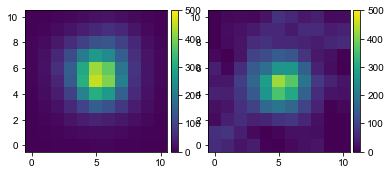

In [14]:
fig, [axis1,axis2] = plt.subplots(1,2)

im1 = axis1.imshow(model.psf * 6, origin='lower', vmin=0, vmax=500)
div1 = make_axes_locatable(axis1)
cax1 = div1.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax1, orientation='vertical')

im2 = axis2.imshow(imcopy[1976-5:1976+6,2950-5:2950+6]*5123.501098, origin='lower', vmin=0,vmax=500)
div2 = make_axes_locatable(axis2)
cax2 = div2.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax2, orientation='vertical')

plt.show()


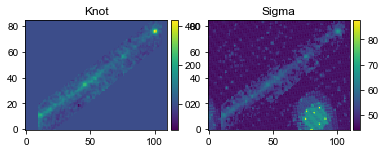

In [15]:
#sanity check: plot model arc, sigma

fig, ([ax1, ax2]) = plt.subplots(1,2)

im1 = ax1.imshow(model.arcim, origin='lower')
div1 = make_axes_locatable(ax1)
cax1 = div1.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax1, orientation='vertical')
ax1.set_title('Knot')

im2 = ax2.imshow(model.sigma, origin='lower')
div2 = make_axes_locatable(ax2)
cax2 = div2.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax2, orientation='vertical')
ax2.set_title('Sigma')

plt.show()

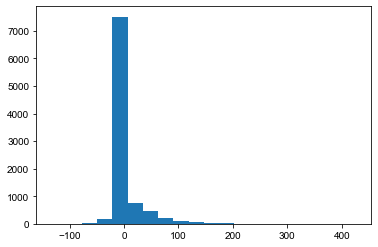

0.0

In [16]:
plt.hist(model.arcim.flatten(), bins=20)
plt.show()
np.median(model.arcim.flatten())

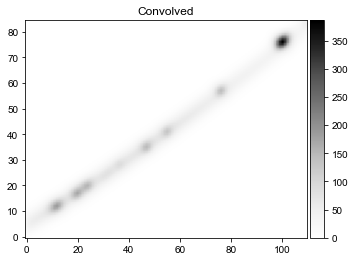

In [30]:
thetatest=np.array([6e4, 1e-2, 
                    100, 1, 
                    3e4, 1e-2, 
                    3e4, 1e-2, 
                    3e4, 1e-2, 
                    2e4, 1e-2, 
                    2e4, 1e-2, 
                    2e4, 1e-2])
#thetatest = np.array([6e4, 1e-2, 
#                     1000, .1, 
#                     1000, 0.1])
convolved = model.convolved(thetatest)

fig, ax3 = plt.subplots()

im3 = ax3.imshow(convolved, origin='lower', cmap='Greys')
div3 = make_axes_locatable(ax3)
cax3 = div3.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im3, cax=cax3, orientation='vertical')
ax3.set_title('Convolved')
#ax3.set_yticks([])
#ax3.set_xticks([])

plt.show()

In [123]:
pix_to_pc(1,6.2)

336.514171886833

In [17]:
init = np.array([6e4, 1e-2, 
                    100, 1, 
                    3e4, 1e-2, 
                    3e4, 1e-2, 
                    3e4, 1e-2, 
                    2e4, 1e-2, 
                    2e4, 1e-2, 
                    2e4, 1e-2]) 
#init = np.array([6e4, 1e-2, 
#                     1000, .1, 
#                     1000, 0.1])
fit = model.min_fit(init)
print(fit)

 final_simplex: (array([[6.89290177e+04, 8.67472584e-03, 1.89498107e+02, 6.19615576e-01,
        2.22766148e+04, 1.49475728e-02, 2.59842106e+04, 1.15542730e-02,
        1.80905379e+04, 1.39040687e-02, 3.49205947e+04, 4.00033399e-03,
        7.21601271e+03, 1.30131956e-02, 1.92077256e+04, 8.51451447e-03],
       [6.89290177e+04, 8.67472584e-03, 1.89498108e+02, 6.19615576e-01,
        2.22766147e+04, 1.49475728e-02, 2.59842106e+04, 1.15542730e-02,
        1.80905378e+04, 1.39040687e-02, 3.49205947e+04, 4.00033399e-03,
        7.21601268e+03, 1.30131956e-02, 1.92077256e+04, 8.51451446e-03],
       [6.89290178e+04, 8.67472584e-03, 1.89498108e+02, 6.19615576e-01,
        2.22766147e+04, 1.49475728e-02, 2.59842106e+04, 1.15542730e-02,
        1.80905378e+04, 1.39040687e-02, 3.49205947e+04, 4.00033399e-03,
        7.21601270e+03, 1.30131956e-02, 1.92077256e+04, 8.51451446e-03],
       [6.89290177e+04, 8.67472584e-03, 1.89498108e+02, 6.19615576e-01,
        2.22766147e+04, 1.49475728e-02, 2.59

In [32]:
PHOTFNU = 6.7784441E-08 # Inverse sensitivity, Jy*sec/e-
print(pix_to_pc(fit.x[1], 6.2))
print(2*np.pi*fit.x[0]*fit.x[1]**2 * PHOTFNU * 1e9)
#print(pix_to_pc(fit.x[3], 6.2))
#print(2*np.pi*fit.x[2]*fit.x[3]**2 * PHOTFNU * 1e9)

0.16657479749791446
0.10614984198811933


In [19]:
mcmcfile = 'whl0137/knots/knotfit_chains/arc/ltm_8gauss_0p1res_2kstep.h5'
theta_init = np.array([2.73248478e+02, 1.14042190e-03]) 
#                       4.21419319e-02, 7.86188738e-01])
#                       7.40247078e+03, 8.39735429e-06])
sampler, autocorr, index = model.runMCMC(fit.x,
                                         niter=2000,
                                         nwalkers=32,
                                         full_output=True,
                                         multiprocess=True,
                                         #n_core=4,
                                         outfile=mcmcfile)

  0%|          | 0/2000 [00:00<?, ?it/s]/home/brian/.local/lib/python3.6/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 2000/2000 [4:32:42<00:00,  8.18s/it]  


In [16]:
mcmcfile = 'whl0137/knots/knotfit_chains/arc/ltm_8gauss_0p1res_2kstep.h5'
#mcmcfile = 'whl0137/knots/knotfit_chains/arc/lenstool_8gauss_init_500.h5'
#mcmcfile = 'whl0137/knots/knotfit_chains/arc/sevengauss_0p1res_500step.h5'
reader = emcee.backends.HDFBackend(mcmcfile)
samples = reader.get_chain(discard=100,flat=True)
lprob = reader.get_log_prob(discard=100,flat=True)

#samples = sampler.get_chain(discard=100, flat=True)
#lprob = sampler.get_log_prob(discard=100, flat=True)

In [17]:
def IQR(dist):
    q75, q25 = np.percentile(dist, [84, 16])
    return (q75 - q25) / 2.

def asym_IQR(dist, hi=84, lo=16):
    q_hi, med, q_lo = np.percentile(dist, [hi, 50, lo])
    return q_hi-med, med-qlo

def flux_to_mag(f_nJy):
    # assumes flux in nJy
    return 31.4 - 2.5 * np.log10(f_nJy)

def app_to_abs(mag, z):
    cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
    mu = cosmo.distmod(z).value
    kcorr = 2.5*np.log10(1+z) # approx., assuming ~flat rest-UV spectrum
    return mag - mu + kcorr - 0.05 #0.05 is dust extinction from milky way (i think)

def amp_to_flux_njy(amp, reff, PHOTFNU = 6.7784441E-08, t_exp=5123.501098):
    flux_e = 2. * np.pi * amp * reff**2
    conv = PHOTFNU / t_exp # Jy *sec/e- to Jy/e-
    flux_njy = flux_e * conv * 1e9
    return flux_njy

def sfr_from_fit_c13(amps, reffs, z=6.2, pivot_wl=11534., PHOTFNU=6.7784441E-08, t_exp=5123.501098):
    fluxes = amp_to_flux_njy(amps, reffs, PHOTFNU, t_exp) # flux in nJy
    fluxes /= (1+z) # 1+z bandwidth compression correction
    mags = flux_to_mag(fluxes) * u.ABmag # convert to magnitudes
    # calculate flux density f_\lambda in erg/s/cm2/Angstrom
    f_lambda = mags.to(u.erg/u.s/u.cm**2/u.AA, u.spectral_density(pivot_wl * u.AA))
    # define angular diameter distance for conversion to luminosity
    cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
    dist6p2 = cosmo.luminosity_distance(z)#.value
    dist_cm = dist6p2.to(u.cm)
    # calculate luminosity from flux
    L_lambda = f_lambda * 4. * np.pi * dist_cm**2 * pivot_wl * u.AA#integrated_thruput * u.AA
    sfr = 3e-47 * pivot_wl * u.AA * L_lambda
    return sfr.value

def sfr_from_fit_k98(amps, reffs, z=6.2, pivot_wl=11534., PHOTFNU=6.7784441E-08, t_exp=5123.501098):
    fluxes = amp_to_flux_njy(amps, reffs, PHOTFNU, t_exp) # flux in nJy
    flux_u = fluxes * u.nJy / (1+z) # divide by 1+z to correct for bandwidth compression
    fnus = flux_u.to(u.erg/u.s/u.cm**2/u.Hz, u.spectral_density(pivot_wl * u.AA))
    # define angular diameter distance for conversion to luminosity
    cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
    dist6p2 = cosmo.luminosity_distance(z)#.value
    dist_cm = dist6p2.to(u.cm)
    Lnus = fnus * 4. * np.pi * dist_cm**2
    const = 1.15e-28
    sfrs = const * Lnus 
    return sfrs.value

thrufile = np.loadtxt('hst_filters/wfc3_ir_f110w.txt')
thrufile = np.loadtxt('hst_filters/wfc3_ir_f110w.txt')
wavs = thrufile[:,0]
thrus = thrufile[:,1]
d_wav = [wavs[i+1] - wavs[i] for i in range(len(wavs)-1)]
d_wav.append(10.0)
integrated = sum(d_wav * thrus)

count = 0
for i in range(len(model.clumps)):
    n_params = model.clumps[i].get_num_params()
    profile = model.clumps[i].profile
    #print(profile, n_params)
    #amp_ind = 3*i
    #rad_ind = 3*i +1
    #n_ind = 3*i + 2
    inds = np.arange(count, count+n_params)
    count += n_params
    #print(inds, count)
    if profile == "Gaussian":
        #sfr_c13 = sfr_from_fit_c13(samples[:,inds[0]], samples[:,inds[1]])
        sfr_k98 = sfr_from_fit_k98(samples[:,inds[0]], samples[:,inds[1]])
        sig_sfr = (0.68*sfr_k98) / (np.pi * (pix_to_pc(samples[:,inds[1]],6.2) * 1e-3)**2) # Msun/yr/kpc^2
        fluxes = amp_to_flux_njy(samples[:,inds[0]], samples[:,inds[1]])
        mags = flux_to_mag(fluxes)
        abs_mags = app_to_abs(mags, 6.2)
    #
    print(np.percentile(fluxes,(16,50,84)))
    print(np.std(fluxes))
    print("Knot {}: Amp = {:.3f} +/- {:.3f}, [{:.2f} - {:.2f}]".format(i, 
                                            np.median(samples[:,inds[0]]), 
                                            IQR(samples[:,inds[0]]),
                                            np.percentile(samples[:,inds[0]],16),
                                            np.percentile(samples[:,inds[0]],84)))
#    print("Knot {}: SFR (C13) = {:.4f} +/- {:.4f}, [{:.4f} - {:.4f}]".format(i,
#                                            np.median(sfr_c13),
#                                            IQR(sfr_c13),
#                                            np.percentile(sfr_c13, 16),
#                                           np.percentile(sfr_c13, 84)))
    print("Knot {}: SFR (K98) = {:.4f} +/- {:.4f}, [{:.4f} - {:.4f}]".format(i,
                                            np.median(sfr_k98),
                                            IQR(sfr_k98),
                                            np.percentile(sfr_k98, 16),
                                            np.percentile(sfr_k98, 84)))
    print("Knot {}: M_UV = {:.4f} +/- {:.4f}, [{:.4f} - {:.4f}]".format(i,
                                            np.median(abs_mags),
                                            IQR(abs_mags),
                                            np.percentile(abs_mags, 16),
                                            np.percentile(abs_mags, 84)))
#    print("Knot {}: R1_pix = {:.3f} +/- {:.3f}, [{:.2f} - {:.2f}]".format(i, 
#                                              np.median(samples[:,inds[1]]), 
#                                              IQR(samples[:,inds[1]]),
#                                             np.percentile(samples[:,inds[1]],16),
#                                           np.percentile(samples[:,inds[1]],84)))
    print("Knot {}: R1_pc = {:.3f} +/- {:.3f}, [{:.2f} - {:.2f}]".format(i,
                                             pix_to_pc(np.median(samples[:,inds[1]]),6.2), 
                                             pix_to_pc(IQR(samples[:,inds[1]]),6.2),
                                             pix_to_pc(np.percentile(samples[:,inds[1]],68),6.2),
                                             pix_to_pc(np.percentile(samples[:,inds[1]],95),6.2)))
    print("Knot {}: Sigma_SFR = {:.3f} +/- {:.3f}, [{:.2f} - {:.2f}]".format(i, 
                                            np.median(sig_sfr), 
                                            IQR(sig_sfr),
                                            np.percentile(sig_sfr,16),
                                            np.percentile(sig_sfr,84)))
    if profile == "Sersic": 
        print("Knot {}: n = {:.2f} +/- {:.2f}".format(i,
                                                 np.median(samples[:,inds[2]]),
                                                 IQR(samples[:,inds[2]])))
        print("Knot {}: e = {:.2f} +- {:.2f}".format(i,
                                                    np.median(samples[:,inds[3]]),
                                                    IQR(samples[:,inds[3]])))
        print("Knot {}: theta = {:.2f} +/- {:.2f}".format(i,
                                                         np.median(samples[:,inds[4]]),
                                                         np.median(samples[:,inds[4]])))
    if profile == "Gaussian-asym":
        print("Knot {}: R2_pix = {:.3f} +/- {:.3f}, [{:.2f} - {:.2f}]".format(i,
                                                          np.median(samples[:,inds[2]]),
                                                          np.median(samples[:,inds[2]]),
                                                          np.percentile(samples[:,inds[2]], 16),
                                                          np.percentile(samples[:,inds[2]], 84)))
        print("Knot {}: R1_pc = {:.3f} +/- {:.3f}, [{:.2f} - {:.2f}]".format(i,
                                                 pix_to_pc(np.median(samples[:,inds[2]]),6.2), 
                                                 pix_to_pc(IQR(samples[:,inds[2]]),6.2),
                                                 pix_to_pc(np.percentile(samples[:,inds[2]],16),6.2),
                                                 pix_to_pc(np.percentile(samples[:,inds[2]],84),6.2)))
        print("Knot {}: theta = {:.2f} +/- {:.2f}".format(i,
                                                         np.median(samples[:,inds[3]]),
                                                         IQR(samples[:,inds[3]])))
    print()

[0.3867867  0.42500892 0.46493544]
0.038366266161641384
Knot 0: Amp = 68929.024 +/- 1191.622, [67827.54 - 70210.78]
Knot 0: SFR (K98) = 0.0292 +/- 0.0027, [0.0266 - 0.0320]
Knot 0: M_UV = -14.4674 +/- 0.0999, [-14.5649 - -14.3651]
Knot 0: R1_pc = 2.895 +/- 0.142, [2.96 - 3.12]
Knot 0: Sigma_SFR = 752.763 +/- 13.014, [740.73 - 766.76]

[5.31369518 5.91435479 6.50982229]
0.6073034468744226
Knot 1: Amp = 189.732 +/- 39.910, [162.97 - 242.79]
Knot 1: SFR (K98) = 0.4065 +/- 0.0411, [0.3652 - 0.4474]
Knot 1: M_UV = -17.3261 +/- 0.1102, [-17.4303 - -17.2099]
Knot 1: R1_pc = 203.862 +/- 25.592, [212.73 - 262.26]
Knot 1: Sigma_SFR = 2.072 +/- 0.436, [1.78 - 2.65]

[0.30820029 0.42860772 0.54585679]
0.12017040779799251
Knot 2: Amp = 22276.610 +/- 7488.059, [14255.96 - 29232.07]
Knot 2: SFR (K98) = 0.0295 +/- 0.0082, [0.0212 - 0.0375]
Knot 2: M_UV = -14.4765 +/- 0.3103, [-14.7391 - -14.1185]
Knot 2: R1_pc = 5.085 +/- 1.324, [5.60 - 9.64]
Knot 2: Sigma_SFR = 243.279 +/- 81.776, [155.69 - 319.24]



In [18]:
def flux_to_Lnu(flux, z, pivot_wl):
    flux_u = flux * u.nJy / (1+z) # divide by 1+z to correct for bandwidth compression
    fnus = flux_u.to(u.erg/u.s/u.cm**2/u.Hz, u.spectral_density(pivot_wl * u.AA))
    # define angular diameter distance for conversion to luminosity
    cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
    dist6p2 = cosmo.luminosity_distance(z)#.value
    dist_cm = dist6p2.to(u.cm)
    Lnu = fnus * 4. * np.pi * dist_cm**2
    return Lnu

count = 0
for i in range(len(model.clumps)):
    n_params = model.clumps[i].get_num_params()
    profile = model.clumps[i].profile
    inds = np.arange(count, count+n_params)
    count += n_params
    fluxes = amp_to_flux_njy(samples[:,inds[0]], samples[:,inds[1]])
    print("Knot {}: Lnu = {:.2e}".format(i, np.median(flux_to_Lnu(fluxes, 6.2, 11534.))))


Knot 0: Lnu = 2.54e+26 erg / (Hz s)
Knot 1: Lnu = 3.53e+27 erg / (Hz s)
Knot 2: Lnu = 2.56e+26 erg / (Hz s)
Knot 3: Lnu = 1.84e+26 erg / (Hz s)
Knot 4: Lnu = 1.85e+26 erg / (Hz s)
Knot 5: Lnu = 3.90e+25 erg / (Hz s)
Knot 6: Lnu = 6.04e+25 erg / (Hz s)
Knot 7: Lnu = 6.89e+25 erg / (Hz s)


In [19]:
import astropy.units as u

def flux_to_mag(f_nJy):
    # assumes flux in nJy
    return 31.4 - 2.5 * np.log10(f_nJy)

def amp_to_flux_njy(amp, reff, PHOTFNU = 6.7784441E-08, t_exp=5123.501098):
    flux_e = 2. * np.pi * amp * reff**2
    conv = PHOTFNU / t_exp # Jy *sec/e- to Jy/e-
    flux_njy = flux_e * conv * 1e9
    return flux_njy

def sfr_from_fit(amps, reffs, integrated_thruput=2500., PHOTFNU=6.7784441E-08):
    fluxes = amp_to_flux_njy(amps, reffs) # flux in nJy
    mags = flux_to_mag(fluxes) * u.ABmag # convert to magnitudes
    # calculate flux density f_\lambda in erg/s/cm2/Angstrom
    f_lambda = mags.to(u.erg/u.s/u.cm**2/u.AA, u.spectral_density(11534. * u.AA))
    # define angular diameter distance for conversion to luminosity
    cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
    dist6p2 = cosmo.luminosity_distance(6.2)#.value
    dist_cm = dist6p2.to(u.cm)
    # calculate luminosity from flux
    L_lambda = f_lambda * 4. * np.pi * dist_cm**2 * integrated_thruput * u.AA
    sfr = 3e-47 * 11534. * u.AA * L_lambda
    return sfr


cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
dist6p2 = cosmo.luminosity_distance(6.2)#.value
dist_cm = dist6p2.to(u.cm)
#print(dist6p2, dist_pc)

thrufile = np.loadtxt('hst_filters/wfc3_ir_f110w.txt')
thrufile = np.loadtxt('hst_filters/wfc3_ir_f110w.txt')
wavs = thrufile[:,0]
thrus = thrufile[:,1]
d_wav = [wavs[i+1] - wavs[i] for i in range(len(wavs)-1)]
d_wav.append(10.0)
integrated = sum(d_wav * thrus)


# bright knot test case: 
# mag = 32,  sfr = 0.03 msun/yr,  flux = 0.58 njy from Dan's spreadsheet

amps = samples[:, 0]
reffs = samples[:, 1]

fluxes = amp_to_flux_njy(amps, reffs) #* 3e-4
#print(fluxes)
print("Flux: %.2f +- %.2f nJy" %(np.median(fluxes), np.std(fluxes)))

mags = flux_to_mag(fluxes)
#print(mags)
print("Mag: %.2f +- %.2f ABmag" %(np.median(mags),np.std(mags)))
#mags = 32.

mags_u = mags * u.ABmag
flams = mags_u.to(u.erg/u.s/u.cm**2/u.AA, u.spectral_density(11534. * u.AA))
#print(flams)
print("Flam: %.2e +- %.2e erg/s/cm2/AA" %(np.median(flams).value, np.std(flams).value))

Llams = flams * 4. * np.pi * dist_cm**2 * integrated * u.AA
#print(Llams)# * 2500 * u.AA)
print("Llam: %.2e +- %.2e erg/s/AA" %(np.median(Llams).value, np.std(Llams).value))

const = 3e-47
sfrs = const * 11534.*u.AA * Llams 
#print(sfrs)
print("SFR: %.2e +- %.2e Msun/yr" %(np.median(sfrs).value, np.std(sfrs).value))
#print(10**((np.log10(Llams.value) - 43.61)/0.96))


sfr2 = sfr_from_fit(amps, reffs, integrated_thruput=integrated)
print("SFR: %.2e +- %.2e Msun/yr" %(np.median(sfr2).value, np.std(sfr2).value))


Flux: 0.43 +- 0.04 nJy
Mag: 32.33 +- 0.10 ABmag
Flam: 9.58e-23 +- 8.65e-24 erg/s/cm2/AA
Llam: 1.01e+41 +- 9.15e+39 erg/s/AA
SFR: 3.51e-02 +- 3.17e-03 Msun/yr
SFR: 3.51e-02 +- 3.17e-03 Msun/yr


In [25]:
flux_u = fluxes * u.nJy
fnus = flux_u.to(u.erg/u.s/u.cm**2/u.Hz, u.spectral_density(11534. * u.AA))
#print("Fnu: %.2e +- %.2e erg/s/cm2/Hz" %(np.median(fnus).value, np.std(fnus).value))
Lnus = fnus * 4. * np.pi * dist_cm**2
const = 1.4e-28
sfrs = const * Lnus 
print("SFR: %.2e +- %.2e Msun/yr" %(np.median(sfrs).value, np.std(sfrs).value))

SFR: 2.53e-01 +- 2.48e-02 Msun/yr


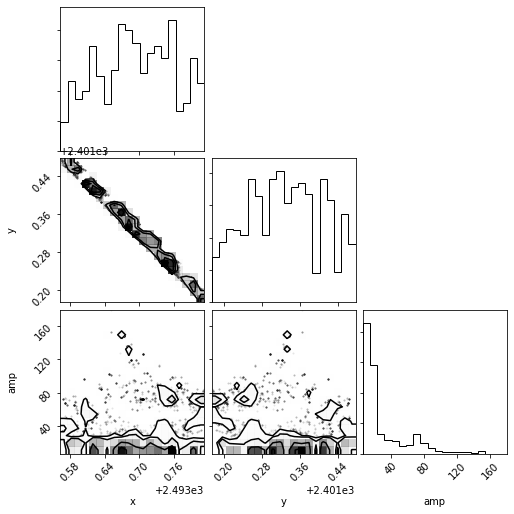

In [47]:
flat_samples = sampler.get_chain(discard=100, flat=True)
labels=["x","y","amp"]
fig = corner.corner(flat_samples,labels=labels)

In [16]:
print(np.median(samples[:,2]),np.std(samples[:,2]))
print(np.median(samples[:,3]), np.std(samples[:,3]))
print(pix_to_pc(np.median(samples[:,3]), 6.2), pix_to_pc(np.std(samples[:,3]), 6.2))
print(np.sqrt(2*np.log(2))*pix_to_pc(np.median(samples[:,3]), 6.2))

0.049263801070436174 0.0037330189666784793
0.6067735830338536 0.031322267997484665
204.18790981744377 10.540387076791003
240.4128914955442


In [21]:
sampler.get_autocorr_time(tol=0)
#reader.get_autocorr_time(tol=0)

array([2034.93852397, 2121.87662553, 2403.57428992, 2352.39197176,
       2365.75621983, 2684.20254136, 1919.08661188, 1729.88139726,
       1853.330606  , 2004.71318314, 1963.30825699, 1874.01753059,
       1382.9472067 , 1706.52271039, 1857.40479918, 1795.11650076])

In [84]:
%matplotlib notebook

In [15]:
200*np.pi

628.3185307179587

[68929.02376582986, 0.008601925406583933, 189.73197745340727, 0.6058043354501131, 22276.609632550317, 0.01511014646462297, 25984.20931573135, 0.011989954063961004, 18090.49087675438, 0.014545218058319999, 34920.60548222363, 0.004739382200739382, 7214.977317821467, 0.013780860162412777, 19207.736915991918, 0.00842589235443707]


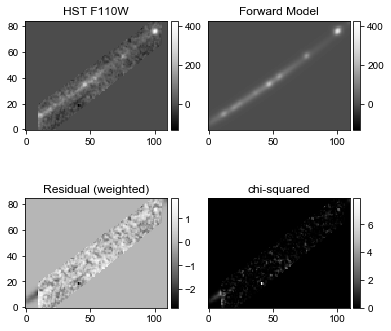

739.9869
0.07914298154453543


In [18]:
#sanity check 2: plot relensed arc w/ fit params, see if it looks right
#theta = [1.9, 0.02, 1.9, 0.2, 1000., 0.0001]#, 0.9, 0.2]#, 0.9, 0.02, 0.9, 0.02]
#theta = fit.x
#theta = [1e15, 2493.68767944, 2401.33947527]#, 200., 0.00001]
#theta = [np.median(samples[:,0]), np.median(samples[:,1]),#, np.median(samples[:,2])]
#         np.median(samples[:,2]), np.median(samples[:,3]),
#         np.median(samples[:,4]), np.median(samples[:,5]),
#         np.median(samples[:,6]), np.median(samples[:,7])]
#theta = [amax[0],rmax[0]]
theta = [np.median(samples[:,0]), np.median(samples[:,1]), np.median(samples[:,2]),
         np.median(samples[:,3]), np.median(samples[:,4]), np.median(samples[:,5]),
         np.median(samples[:,6]), np.median(samples[:,7]), np.median(samples[:,8]),
         np.median(samples[:,9]), np.median(samples[:,10]), np.median(samples[:,11]),
         np.median(samples[:,12]), np.median(samples[:,13]), np.median(samples[:,14]),
         np.median(samples[:,15])]


print(theta)

cv = model.convolved(theta) #* 20617.481562
arcimage = np.copy(model.arcim) #np.copy(model.arcim)# 

simimage =  np.copy(model.simim) # np.zeros_like(arcimage) #
simimage[:,:] += cv[:,:]

Xsq = model.chisquared(theta)
diff = arcimage - simimage
diff_weighted = diff / model.sigma

col_min = min(arcimage.flatten())
col_max = max(arcimage.flatten())


fig, ([ax1, ax2],[ax3, ax4]) = plt.subplots(2, 2, figsize=(6,6))


im1 = ax1.imshow(arcimage, origin='lower', cmap='Greys_r', vmin=col_min, vmax=col_max)#, norm=norm)#)##)

div1 = make_axes_locatable(ax1)
cax1 = div1.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax1, orientation='vertical')
ax1.set_title('HST F110W')
#ax1.set_xticks([])
#ax1.set_yticks([])

im2 = ax2.imshow(simimage, origin='lower', cmap='Greys_r', vmin=col_min, vmax=col_max)#, norm=norm2)#)##)

div2 = make_axes_locatable(ax2)
cax2 = div2.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax2, orientation='vertical')
ax2.set_title('Forward Model')
#ax2.set_xticks([])
ax2.set_yticks([])

im3 = ax3.imshow(diff_weighted, origin='lower', cmap='Greys_r')#, vmin=-2, vmax=2)

div3 = make_axes_locatable(ax3)
cax3 = div3.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im3, cax=cax3, orientation='vertical')
ax3.set_title('Residual (weighted)')
#ax4.set_xticks([])
#ax4.set_yticks([])


im4 = ax4.imshow(Xsq, origin='lower', cmap='Greys_r')#, vmin=-0.01, vmax=0.01)

div4 = make_axes_locatable(ax4)
cax4 = div4.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im4, cax=cax4, orientation='vertical')
ax4.set_title('chi-squared')
#ax4.set_xticks([])
ax4.set_yticks([])


#plt.savefig('whl0137/starpaper/plots/arc_fit_resid2.pdf',
#            bbox_inches='tight',pad_inches=0)

plt.show()

print(np.sum(Xsq))
print(np.sum(Xsq) / len(Xsq.flatten()))

In [20]:
def pc_to_pix(r_pc, z):
    cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
    DA = cosmo.angular_diameter_distance_z1z2(0 , z).value * 10**6 #returns in pc
    theta = r_pc / DA # radian
    theta = theta * (180 / np.pi) * 3600 # arcsec
    pixSize = 0.06 #HST WFC3 pixel size
    rpix = theta / pixSize
    return rpix


[68965.54076444611, 0.008794653396539284, 189.73197745340727, 0.6058043354501131, 22334.394260301204, 0.016650434021497382, 26023.283323640364, 0.012866143199039757, 18131.92527957295, 0.016342533987679212, 35049.04918629457, 0.005238680071852525, 7217.300891163915, 0.01629523058019297, 19377.089435683007, 0.009115668873052407]
3125.7559649711366 3126.0
(1000, 1000)


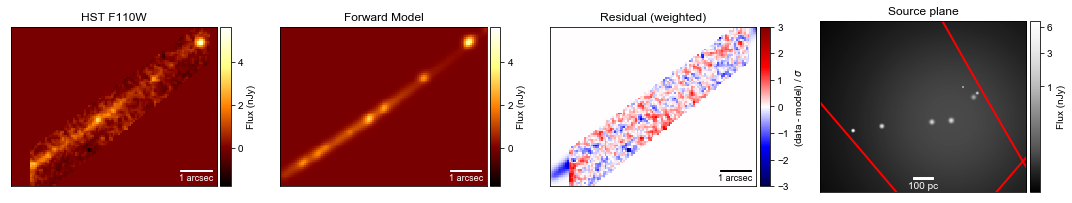

In [23]:
#################################################################
# PAPER FIGURE
#################################################################
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
fontprops = fm.FontProperties(size=9)

#theta = [np.median(samples[:,0]), np.median(samples[:,1]), np.median(samples[:,2]),
#         np.median(samples[:,3]), np.median(samples[:,4]), np.median(samples[:,5]),
#         np.median(samples[:,6]), np.median(samples[:,7]), np.median(samples[:,8]),
#         np.median(samples[:,9]), np.median(samples[:,10]), np.median(samples[:,11]),
#         np.median(samples[:,12]), np.median(samples[:,13]), np.median(samples[:,14]),
#         np.median(samples[:,15])]
theta = [np.percentile(samples[:,0],68), np.percentile(samples[:,1],68), np.percentile(samples[:,2],50),
         np.percentile(samples[:,3],50), np.percentile(samples[:,4],68), np.percentile(samples[:,5],68),
         np.percentile(samples[:,6],68), np.percentile(samples[:,7],68), np.percentile(samples[:,8],68),
         np.percentile(samples[:,9],68), np.percentile(samples[:,10],68), np.percentile(samples[:,11],68),
         np.percentile(samples[:,12],68), np.percentile(samples[:,13],68), np.percentile(samples[:,14],68),
         np.percentile(samples[:,15],68)]


print(theta)

PHOTFNU=6.7784441E-08
t_exp=5123.501098
electron_to_njy = (PHOTFNU / t_exp) * 1e9

cv = model.convolved(theta) #* 20617.481562
arcimage = np.copy(model.arcim) #np.copy(model.arcim)# 
arcimage_njy = arcimage * electron_to_njy

simimage =  np.copy(model.simim) # np.zeros_like(arcimage) #
simimage[:,:] += cv[:,:]
simimage_njy = simimage * electron_to_njy

Xsq = model.chisquared(theta)
diff = arcimage - simimage
diff_weighted = diff / model.sigma

col_min = min(arcimage_njy.flatten())
col_max = max(arcimage_njy.flatten())

# make source plane image
# make caustic curves
cc_pts = con.collections[0].get_paths()
#print(cc_pts)
cc_v = [cc_pts[i].vertices for i in range(len(cc_pts))]
cc_v2 = np.concatenate(cc_v)

cc_x = cc_v2[:,0]
cc_y = cc_v2[:,1]
#print(cc_v2.shape)
print(cc_x[0],cc_x[0].round())

caustic_x = []
caustic_y = []
for i in range(len(cc_x)):
    xpos = int(cc_x[i].round())
    ypos = int(cc_y[i].round())
    #print(xpos,ypos)
    caustic_x.append(xpos - ax[ypos, xpos])
    caustic_y.append(ypos - ay[ypos, xpos])

caustic_x = np.array(caustic_x)
caustic_y = np.array(caustic_y)
#LTM source plane
#xlo, xhi = 2493, 2498
sxlo, sxhi = 2493.5, 2496.5
sylo, syhi = 2400.25, 2402.75
#ylo, yhi = 2399, 2404

nnxx = np.linspace(sxlo, sxhi, 1000) 
nnyy = np.linspace(sylo, syhi, 1000) 
xxx, yyy = np.meshgrid(nnxx, nnyy)

amp1, reff1, amp2, reff2, amp3, reff3, amp4, reff4, amp5, reff5, amp6, reff6, amp7, reff7, amp8, reff8 = theta
#amp6 *= 10
#amp7 *= 10
#amp8 *= 10
#reff7 *= 100

gauss1 = Gaussian2D(amp1, x_mean=xs1, y_mean=ys1, x_stddev=reff1, y_stddev=reff1) #bright knot
gauss2 = Gaussian2D(amp2, x_mean=xs2, y_mean=ys2, x_stddev=reff2, y_stddev=reff2) #diffuse
gauss3 = Gaussian2D(amp3, x_mean=xs2, y_mean=ys2, x_stddev=reff3, y_stddev=reff3) #central knot
gauss4 = Gaussian2D(amp4, x_mean=xs3, y_mean=ys3, x_stddev=reff4, y_stddev=reff4) #small iso
gauss5 = Gaussian2D(amp5, x_mean=xs4, y_mean=ys4, x_stddev=reff5, y_stddev=reff5) #small central
gauss6 = Gaussian2D(amp6, x_mean=xs5, y_mean=ys5, x_stddev=reff6, y_stddev=reff6) #5
gauss7 = Gaussian2D(amp7, x_mean=xs6, y_mean=ys6, x_stddev=reff7, y_stddev=reff7) #6
gauss8 = Gaussian2D(amp8, x_mean=xs7, y_mean=ys7, x_stddev=reff8, y_stddev=reff8) #7
#gauss9 = Gaussian2D(2., x_mean=xs8, y_mean=ys8, x_stddev=0.01, y_stddev=0.01) # star
#gauss10 = Gaussian2D(2., x_mean=xs9, y_mean=ys9, x_stddev=0.01, y_stddev=0.01) # X

combined = gauss1 + gauss2 + gauss3 + gauss4 + gauss5 + gauss6 + gauss7 + gauss8

source_show = combined(xxx, yyy)
source_show_njy = (source_show * electron_to_njy) / 130.
print(source_show.shape)

scale = pc_to_pix(100., 6.2)
scaleplot = scale #* np.sqrt(70) # account for magnification


fig, ([ax1,ax2,ax3,ax4]) = plt.subplots(1, 4, figsize=(15,8))


im1 = ax1.imshow(arcimage_njy, origin='lower', cmap='afmhot', vmin=col_min, vmax=col_max)#, norm=norm)#)##)

div1 = make_axes_locatable(ax1)
cax1 = div1.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax1, orientation='vertical', label='Flux (nJy)')
ax1.set_title('HST F110W')
scalebar = AnchoredSizeBar(ax1.transData,
                          16.67, '1 arcsec','lower right',
                          pad=0.3,
                          color='white',
                          frameon=False,
                          size_vertical=.75,
                          fontproperties=fontprops)#,
                          #fontsize=5)
ax1.add_artist(scalebar)
ax1.set_xticks([])
ax1.set_yticks([])

im2 = ax2.imshow(simimage_njy, origin='lower', cmap='afmhot', vmin=col_min, vmax=col_max)#, norm=norm2)#)##)

div2 = make_axes_locatable(ax2)
cax2 = div2.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax2, orientation='vertical', label='Flux (nJy)')
ax2.set_title('Forward Model')
scalebar = AnchoredSizeBar(ax2.transData,
                          16.67, '1 arcsec','lower right',
                          pad=0.3,
                          color='white',
                          frameon=False,
                          size_vertical=.75,
                          fontproperties=fontprops)#,
                          #fontsize=5)
ax2.add_artist(scalebar)
ax2.set_xticks([])
ax2.set_yticks([])

im3 = ax3.imshow(diff_weighted, origin='lower', cmap='seismic', vmin=-3, vmax=3)

div3 = make_axes_locatable(ax3)
cax3 = div3.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im3, cax=cax3, orientation='vertical', label='(data - model) / $\sigma$')
ax3.set_title('Residual (weighted)')
scalebar = AnchoredSizeBar(ax3.transData,
                          16.67, '1 arcsec','lower right',
                          pad=0.3,
                          color='black',
                          frameon=False,
                          size_vertical=.75,
                          fontproperties=fontprops)#,
                          #fontsize=5)
ax3.add_artist(scalebar)
ax3.set_xticks([])
ax3.set_yticks([])

norm = ImageNormalize(stretch=PowerStretch(a=.25))
im4 = ax4.imshow(source_show_njy, origin='lower', cmap='Greys_r', 
                 norm=norm, extent=[sxlo, sxhi, sylo, syhi])

div4 = make_axes_locatable(ax4)
cax4 = div4.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im4, cax=cax4, orientation='vertical', label='Flux (nJy)', ticks=[1,3,6])
ax4.set_title('Source plane')
scalebar = AnchoredSizeBar(ax4.transData,
                           scaleplot, '100 pc', 'lower center', 
                           pad=0.1,
                           color='white',
                           frameon=False,
                           size_vertical=.03)

ax4.add_artist(scalebar)

#ixx = [(caustic_x >= xlo-1) & (caustic_x <= xhi+1) & (caustic_y >= ylo-1) & (caustic_y <= yhi+1)]

#ax1.plot(caustic_x[ixx], caustic_y[ixx], 'r-')
ax4.contour(xss, yss, magnifinv, [0], colors='r', linewidths=2)
#ax1.plot(xs3, ys3, 'yo', fillstyle='none')

ax4.set_xlim(sxlo, sxhi)
ax4.set_ylim(sylo, syhi)
ax4.set_xticks([])
ax4.set_yticks([])



plt.tight_layout()
plt.savefig('arcpaper/plots/sunrise_resid_color_source_uplim_scalefix.png',
            bbox_inches='tight',pad_inches=0)

plt.show()


In [27]:
print(pix_to_pc(theta[1],6.2),
      pix_to_pc(theta[3],6.2),
      pix_to_pc(theta[5],6.2),
      pix_to_pc(theta[7],6.2),
      pix_to_pc(theta[9],6.2),
      pix_to_pc(theta[11],6.2),
      pix_to_pc(theta[13],6.2),
      pix_to_pc(theta[15],6.2))

3.1185409049061317 203.86174426944802 9.643311472399157 5.308750449801004 8.40742352158116 2.357034833388071 11.610445618264968 3.7473412638363395


In [56]:
%matplotlib notebook

425


<IPython.core.display.Javascript object>


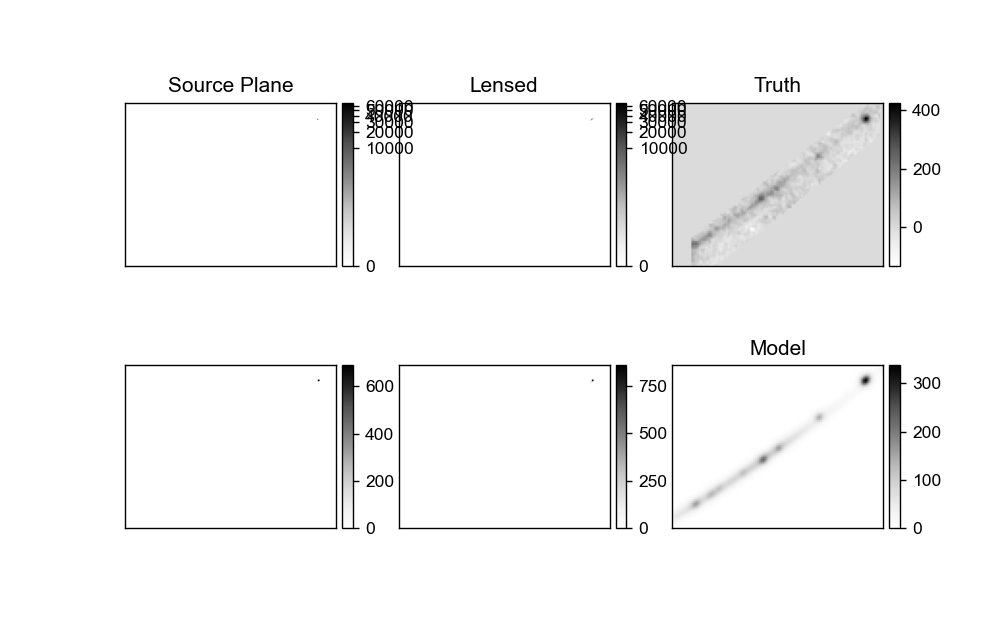

In [58]:
# plot every step of the process - source plane, then lensed, then convolved
def rebin(a, shape):
    """
    Re-bin hi-resolution simulated image to lower (HST) resolution. 
    """
    sh = shape[0], a.shape[0]//shape[0], shape[1], a.shape[1]//shape[1]
    return a.reshape(sh).mean(-1).mean(1)
    #return a.reshape(sh).sum(-1).sum(1)


a1 = fit.x[0]
r1 = 0.003# fit.x[1] 
theta1 = fit.x#(a1, r1, a1, r1, a1, r1, a1, r1, a1, r1, a1, r1, a1, r1, a1, r1)#, n1, ellip1, rot1)

#gauss_source = Sersic2D(a1, r_eff=r1, n=n1, x_0=x1, y_0=y1, ellip=ellip1, theta=rot1)
#gauss_lens = Sersic2D(a1, r_eff=r1, n=n1, x_0=xs1, y_0=ys1, ellip=ellip1, theta=rot1)
gauss_source = Gaussian2D(a1, x_mean=x1, y_mean=y1, x_stddev=r1, y_stddev=r1)
gauss_lens = Gaussian2D(a1, x_mean=xs1, y_mean=ys1, x_stddev=r1, y_stddev=r1)

arcimage = model.arcim

sourceplane = gauss_source(xx_hires, yy_hires)
sourceplane_rebin = rebin(sourceplane, model.arcim.shape)
lensed_hires = gauss_lens(model.xss, model.yss)
lensed_rebin = rebin(lensed_hires, model.arcim.shape)
convolved = model.convolved(theta1)


center = int(lensed_hires.shape[0] / 2.) #- 20
print(center)

norm = ImageNormalize(stretch=LogStretch())

fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2, 3, figsize=(8,5))#,(ax4,ax5,ax6),(ax7,ax8,ax9)

im1 = ax1.imshow(sourceplane, origin='lower', cmap='Greys', norm=norm)
##im1 = ax1.imshow(lensed_rebin, origin='lower', cmap='Greys')
div1 = make_axes_locatable(ax1)
cax1 = div1.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax1, orientation='vertical')
ax1.set_title('Source Plane')
#ax1.set_title('Lensed Rebinned')
ax1.set_yticks([])
ax1.set_xticks([])

im2 = ax2.imshow(lensed_hires, 
                 origin='lower', cmap='Greys', norm=norm)#
div2 = make_axes_locatable(ax2)
cax2 = div2.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax2, orientation='vertical')
ax2.set_title('Lensed')
ax2.set_yticks([])
ax2.set_xticks([])

im3 = ax3.imshow(arcimage, origin='lower', cmap='Greys')
div3 = make_axes_locatable(ax3)
cax3 = div3.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im3, cax=cax3, orientation='vertical')
ax3.set_title('Truth')
ax3.set_yticks([])
ax3.set_xticks([])


im4 = ax4.imshow(sourceplane_rebin, origin='lower', cmap='Greys')#, norm=norm)
#im4 = ax4.imshow(lensed_rebin2, origin='lower', cmap='Greys')
div4 = make_axes_locatable(ax4)
cax4 = div4.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im4, cax=cax4, orientation='vertical')
ax4.set_yticks([])
ax4.set_xticks([])

#im5 = ax5.imshow(lensed_hires2[center-10:center+10,center-10:center+10], 
#                 origin='lower', cmap='Greys', norm=norm)
im5 = ax5.imshow(lensed_rebin, origin='lower', cmap='Greys')
div5 = make_axes_locatable(ax5)
cax5 = div5.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im5, cax=cax5, orientation='vertical')
ax5.set_yticks([])
ax5.set_xticks([])

im6 = ax6.imshow(convolved, origin='lower', cmap='Greys')
div6 = make_axes_locatable(ax6)
cax6 = div6.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im6, cax=cax6, orientation='vertical')
ax6.set_title('Model')
ax6.set_yticks([])
ax6.set_xticks([])
'''
##im7 = ax7.imshow(sourceplane3[890:910,890:910], origin='lower', cmap='Greys', norm=norm)
im7 = ax7.imshow(lensed_rebin3, origin='lower', cmap='Greys')
div7 = make_axes_locatable(ax7)
cax7 = div7.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im7, cax=cax7, orientation='vertical')
ax7.set_yticks([])
ax7.set_xticks([])

im8 = ax8.imshow(lensed_hires3[center-10:center+10,center-10:center+10], 
                 origin='lower', cmap='Greys', norm=norm)
div8 = make_axes_locatable(ax8)
cax8 = div8.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im8, cax=cax8, orientation='vertical')
#ax8.set_yticks([])
#ax8.set_xticks([])

im9 = ax9.imshow(convolved3, origin='lower', cmap='Greys')
div9 = make_axes_locatable(ax9)
cax9 = div9.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im9, cax=cax9, orientation='vertical')
ax9.set_yticks([])
ax9.set_xticks([])
'''
plt.show()


In [14]:
amp = amp[reff>1e-5]
reff = reff[reff>1e-5]

In [38]:
PHOTFNU = 6.7784441E-08 # Inverse sensitivity, Jy*sec/e-

flux = amp * 2 * np.pi * reff**2
print(np.median(flux),np.std(flux))
flux_nJy = flux * PHOTFNU * 1e9
print(np.median(flux_nJy), np.std(flux_nJy))
ratio = flux_nJy / 120.
SFR = ratio * 80 # Msun/yr

print("SFR = %.3e +- %.3e" %(np.median(SFR), np.std(SFR)))

image_flux = 48.79 
image_flux_err = 4.1241
obj_magnif = image_flux / np.median(flux_nJy)
magnif_err_relative = np.sqrt((image_flux_err / image_flux)**2 + (np.std(flux_nJy) / np.median(flux_nJy))**2)
magnif_err = magnif_err_relative * obj_magnif
print("Magnification from Flux: %.2f +- %.2f" %(obj_magnif, magnif_err))

0.0013946624482794692 0.00017228243838375364
0.09453641444031524 0.011678068779959685
SFR = 6.302e-02 +- 7.785e-03
Magnification from Flux: 516.10 +- 77.25


In [27]:
full_magnif = image_flux / flux_nJy
#print(len(full_magnif))
#full_magnif = full_magnif[full_magnif < 10**9]
#print(len(full_magnif))
#mag_hi = (image_flux+image_flux_err) / flux_nJy
#mag_lo = (image_flux-image_flux_err) / flux_nJy
#mag_hilo = np.concatenate((mag_hi,mag_lo))

log_mag = np.log10(full_magnif)
print(np.median(log_mag), np.std(log_mag))
print(np.median(full_magnif), np.std(full_magnif))
print()
#print(np.median(mag_hilo),np.std(mag_hilo))
#log_mag_hilo = np.log10(mag_hilo)
#print(np.median(log_mag_hilo), np.std(log_mag_hilo))
print(min(full_magnif), max(full_magnif))
#print(1. / magnifinv[ye,xe])

2.513647269759834 0.0570480510750414
326.32268803700117 44.80428573642594

204.21337179356217 570.238679207124


In [28]:
n_sigma = 1
confidence = sp.erf(n_sigma / np.sqrt(2))
low_percentile = 100 * (1 - confidence) / 2.
hi_percentile = 100 - low_percentile
percentiles = np.percentile(log_mag, (low_percentile, 50, hi_percentile))
print(percentiles)

err_low = percentiles[1] - percentiles[0]
err_hi = percentiles[2] - percentiles[1]

print("Log(Magnification) = %.2f (+ %.2f) (- %.2f)" %(percentiles[1],err_hi,err_low))
print("Magnification = %.2f (+%.2f) (-%.2f)" 
      %(10**percentiles[1],
        (10**percentiles[2] - 10**percentiles[1]),
         (10**percentiles[1] - 10**percentiles[0])))
print(max(full_magnif))

[2.46131892 2.51364727 2.571798  ]
Log(Magnification) = 2.51 (+ 0.06) (- 0.05)
Magnification = 326.32 (+46.75) (-37.04)
570.238679207124


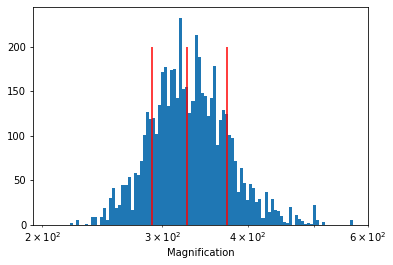

In [29]:
# magnification histogram
logmin, logmax = np.log10(min(full_magnif)), np.log10(max(full_magnif))
logbins = np.logspace(logmin, logmax, num=101)

plt.hist(full_magnif, bins=logbins)#, log=True)
plt.xscale('log')
plt.xlabel('Magnification')
plt.vlines(10**percentiles,0,200, colors='r')
#plt.xlim(1e3,1e7)
plt.show()

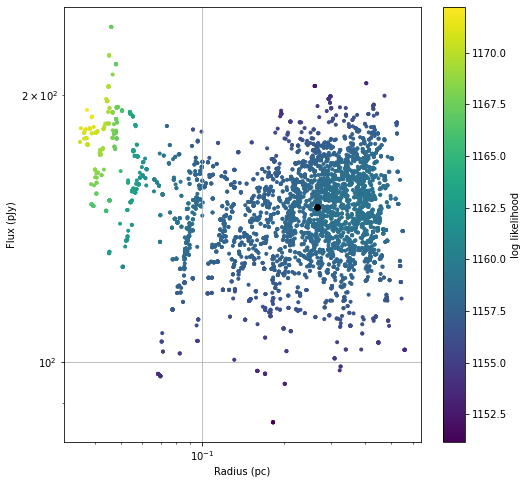

In [30]:
r_parsecs = pix_to_pc(reff, 6.2)
fluxes = (amp * 2 * np.pi * reff**2) * (PHOTFNU * 1e9)

fig = plt.figure(figsize=(8,8))

#plt.scatter(reff, amp, c=lprob, marker='.')
plt.scatter(r_parsecs, fluxes*1e3, c=lprob, marker='.')
#plt.plot(pix_to_pc(rmax, 6.2), amax*2*np.pi*rmax**2*1e3, 'ro')
plt.plot(np.median(r_parsecs), np.median(fluxes)*1e3, 'ko')
#plt.plot(pix_to_pc(4e-5,6.2), 5, 'ro')
#plt.plot(pix_to_pc(1e-4,6.2), 5, 'ro')
#plt.plot(8, 0.05, 'kx')
cb = plt.colorbar(label='log likelihood')
#plt.plot(450, 0.0007, 'ro')
plt.loglog()
#plt.xlabel('R_eff (pixels)')
#plt.ylabel('Amplitude')
plt.xlabel('Radius (pc)')
plt.ylabel('Flux (pJy)')#forward
#plt.yticks(np.linspace(1,10,10))
#plt.xticks(np.linspace(0.001,0.01,10))
plt.grid(True)

#plt.savefig('knotfit/chains/whl0137/lowknot_sersic+gauss_AvsR_log.png')
plt.show()

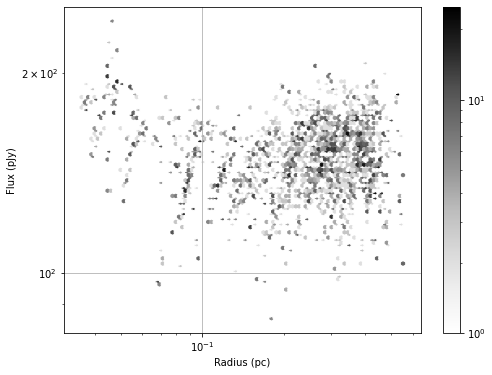

In [31]:
fig = plt.figure(figsize=(8,6))
plt.hexbin(r_parsecs, fluxes*1e3, xscale='log',yscale='log',bins='log',cmap='Greys')
cb = plt.colorbar()
plt.xlabel('Radius (pc)')
plt.ylabel('Flux (pJy)')#forward
#plt.yticks(np.linspace(1,10,10))
#plt.xticks(np.linspace(0.01,0.05,5))
plt.grid(True)
plt.show()

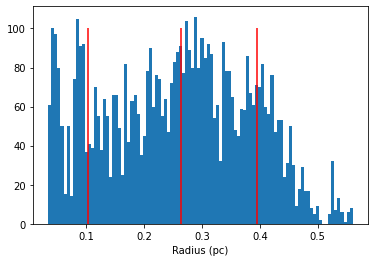

[0.10294265 0.26490729 0.39458959 0.45018657 0.52397281]


In [32]:
plt.hist(r_parsecs, bins=100)
plt.vlines(np.percentile(r_parsecs,(16,50,84)),0,100,colors='r')
plt.xlabel('Radius (pc)')
plt.show()

print(np.percentile(r_parsecs,(16,50,84,95,99)))
#np.percentile(reff[reff>3e-5], 95)

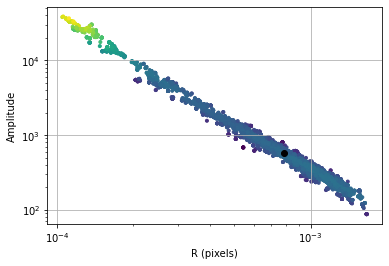

In [33]:
plt.scatter(reff, amp, c=lprob, marker='.')
plt.plot(np.median(reff), np.median(amp), 'ko')
#plt.plot([3e-5,1e-4],[5e3,1e3],'ro')
plt.xlabel('R (pixels)')
plt.ylabel('Amplitude')
plt.loglog()
plt.grid(True)
plt.show()
#print(len(reff[reff>3e-5]),len(reff))

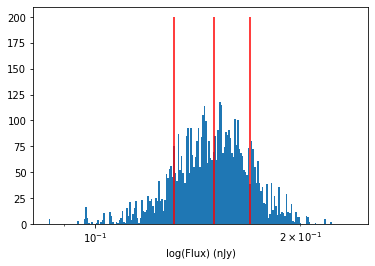

[0.11889456 0.13084382 0.14951458 0.16858444 0.18243237 0.19704014]
log(Flux) (nJy) = -0.83 +(0.05) -(0.06)
Flux (pJy) = 149.51 (+19.07) (-18.67)
149.5145810861141 19.382000342880062


In [34]:
log_flux = np.log10(flux_nJy)
logmin, logmax = np.log10(min(flux_nJy)), np.log10(max(flux_nJy))
logbins = np.logspace(logmin, logmax, num=201)

plt.hist(flux_nJy, bins=logbins)
plt.vlines(np.percentile(flux_nJy,(16,50,84)),0,200,colors='r')
plt.xscale('log')
plt.xlabel('log(Flux) (nJy)')
#plt.xlim(1e-6,0.1)
plt.show()

flux_percentiles = np.percentile(log_flux, (16,50,84))
flux_err_hi = flux_percentiles[2] - flux_percentiles[1]
flux_err_lo = flux_percentiles[1] - flux_percentiles[0]

print(np.percentile(flux_nJy,(5,16,50,84,95,99)))
print("log(Flux) (nJy) = %.2f +(%.2f) -(%.2f)" %(flux_percentiles[1],flux_err_hi,flux_err_lo))
print("Flux (pJy) = %.2f (+%.2f) (-%.2f)" 
     %(10**flux_percentiles[1] * 1e3, 
       (10**flux_percentiles[2] - 10**flux_percentiles[1]) * 1e3,
      (10**flux_percentiles[1] - 10**flux_percentiles[0]) * 1e3))
print(np.median(flux_nJy)*1e3, np.std(flux_nJy)*1e3)

In [35]:
def flux_to_mag(f_nJy):
    # assumes flux in nJy
    return 31.4 - 2.5 * np.log10(f_nJy)

def app_to_abs(mag, d_pc):
    return mag - (5*np.log10(d_pc)) + 5

mags = flux_to_mag(flux_nJy)

mag_percentiles = np.percentile(mags,(16,50,84))
print(mag_percentiles)
print(np.median(mags),np.std(mags))

mag_err_hi = mag_percentiles[2] - mag_percentiles[1]
mag_err_lo = mag_percentiles[1] - mag_percentiles[0]

print("m_AB = %.2f +(%.2f) -(%.2f)" %(mag_percentiles[1],mag_err_hi,mag_err_lo))

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
dist6p2 = cosmo.luminosity_distance(6.2).value
dist6p2 *= 1e6
abs_mags = app_to_abs(mags, dist6p2)
abs_mag_percentiles = np.percentile(abs_mags,(16,50,84))
print(abs_mag_percentiles)
print(np.median(abs_mags),np.std(abs_mags))

abs_mag_err_hi = abs_mag_percentiles[2] - abs_mag_percentiles[1]
abs_mag_err_lo = abs_mag_percentiles[1] - abs_mag_percentiles[0]

print("M = %.2f +(%.2f) -(%.2f)" %(abs_mag_percentiles[1],abs_mag_err_hi,abs_mag_err_lo))


[33.3329563  33.46329113 33.60811699]
33.46329112911892 0.14262012768760338
m_AB = 33.46 +(0.14) -(0.13)
[-15.55675487 -15.42642004 -15.28159418]
-15.4264200428144 0.14262012768760338
M = -15.43 +(0.14) -(0.13)


In [12]:
def flux_to_mag(f_nJy):
    # assumes flux in nJy
    return 31.4 - 2.5 * np.log10(f_nJy)

def app_to_abs(mag, d_pc):
    return mag - (5*np.log10(d_pc)) + 5

def app_to_abs2(mag, d_pc):
    return mag - 5 * (np.log10(d_pc) - 1) + 2.1

#print(flux_to_mag(.00575))
#print(np.log10(0.003) - np.log10(0.00575))
#print(np.log10(0.053) - np.log10(0.00575))
#print(np.log10(0.028) - np.log10(0.00575))
#print(np.log10(0.009) - np.log10(0.00575))
#print(np.log10(0.023) - np.log10(0.00575))
#print(np.log10((49000./100000.)/1000.) - np.log10(0.00575))
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
dist6p2 = cosmo.luminosity_distance(6.2).value
dist6p2 *= 1e6
print(app_to_abs(37., dist6p2))
print(app_to_abs2(37., dist6p2))
print(5 * (np.log10(dist6p2) - 1))

-11.889711171933321
-9.789711171933321
48.88971117193332


[2.55754146e+02 3.59454927e-03 7.52400167e-02 5.73453965e-01
 6.15479540e-01 1.54790965e-02 5.40321930e-01 1.68428331e-02
 4.34449067e-01 1.14063747e-02 4.81087215e-01 2.06687971e-03
 4.12721169e-01 3.95163583e-05 1.01568699e+00 3.07438812e-03]


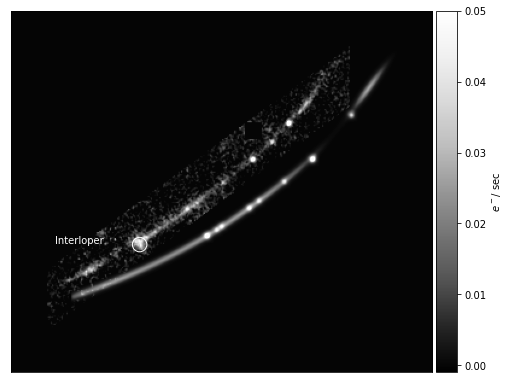

In [17]:
#paper plot
mcmc_arc = 'whl0137/knots/knotfit_chains/knot_arc_mixedres_500step.h5'
#mcmc_star = 'whl0137/knots/knotfit_chains/star/prefit_3kstep.h5'
arc_reader = emcee.backends.HDFBackend(mcmc_arc)
arc_samples = arc_reader.get_chain(discard=100,flat=True)
#star_reader = emcee.backends.HDFBackend(mcmc_star)
#star_samples = star_reader.get_chain(discard=100,flat=True)

#r_star = np.median(star_samples[:,0])
#amp_star = np.median(star_samples[:,1])
r_knot = np.median(arc_samples[:,0])
amp_knot = np.median(arc_samples[:,1])
r_arc = np.median(arc_samples[:,2])
amp_arc = np.median(arc_samples[:,3])

#theta = [r_knot, amp_knot, r_arc, amp_arc]#, r_star, amp_star]
#LTM params:
#theta = np.array([r_knot, amp_knot, #1.41115828e+02, 2.58822551e-03, #1
#                  r_arc, amp_arc, #5.00000000e-02, 7.00000000e-01, #diffuse
#                  5.74863652e-01, 4.42411302e-02, #4
#                  4.31888727e-01, 1.17916968e-02, #2
#                  2.53455727e-01, 4.12753324e-05, #3
#                  3.08655533e-01, 2.05771789e-02, #5
#                  2.82393490e-01, 1.38751528e-02, #6
#                  7.15090146e-01, 2.37301046e-02]) #7
#Lenstool params:
theta = np.array([2.55754146e+02, 3.59454927e-03, # 1
                  7.52400167e-02, 5.73453965e-01, # arc
                  6.15479540e-01, 1.54790965e-02, # 4
                  5.40321930e-01, 1.68428331e-02, # 2
                  4.34449067e-01, 1.14063747e-02, # 3
                  4.81087215e-01, 2.06687971e-03, # 5
                  4.12721169e-01, 3.95163583e-05, # 6
                  1.01568699e+00, 3.07438812e-03]) # 7


#print(r_knot, amp_knot)
print(theta)

cv = model.convolved(theta)
arcimage = np.copy(model.arcim)
simimage =  np.zeros_like(arcimage) # np.copy(model.simim) # 

simimage[:,:] += cv[:,:]
diff = arcimage - simimage

xoffset = 50
#yoffset = -10
arcimage[:,xoffset:] += cv[:,:-xoffset]


xe, ye = 2967-1, 1990
xe_sim, ye_sim = xe+xoffset, ye#+yoffset?

delta = 9

xlo_star,xhi_star = xe-delta, xe+delta
ylo_star,yhi_star = ye-delta, ye+delta
xslice_star = slice(xlo_star-xlo,xhi_star-xlo)
yslice_star = slice(ylo_star-ylo,yhi_star-ylo)

xlo_sim,xhi_sim = xe_sim-delta, xe_sim+delta
ylo_sim,yhi_sim = ye_sim-delta, ye_sim+delta
xslice_sim = slice(xlo_sim-xlo,xhi_sim-xlo)
yslice_sim = slice(ylo_sim-ylo,yhi_sim-ylo)

fig, ax1 = plt.subplots(figsize=(8,8))


im1 = ax1.imshow(arcimage, 
                 origin='lower', cmap='Greys_r', 
                 extent=(xlo,xhi,ylo,yhi),
                 vmin=-0.001, vmax=0.05)#, norm=norm)#)##)

div1 = make_axes_locatable(ax1)
cax1 = div1.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im1, cax=cax1, orientation='vertical')
cbar.set_label('$e^-$/ sec')
#ax1.set_title('HST F110W')
ax1.set_xticks([])
ax1.set_yticks([])
circle = plt.Circle((2857, 1906), 6, color='white', fill=False)
ax1.add_artist(circle)
ax1.text(2857-70, 1907,"Interloper", color='white')
#con = ax1.contour(xx, yy, magnifinv, [0], colors='r', linewidths=2)
ax1.set_xlim(xlo, xhi)
ax1.set_ylim(ylo, yhi)

# add insets showing star, model of star. Add residual somehow? Maybe outside the main figure?
'''
axins1 = ax1.inset_axes([0.05, 0.65, 0.25, 0.25])

axins1.imshow(arcimage[yslice_star,xslice_star],
             origin='lower', cmap='Greys_r',
             extent=(xlo_star,xhi_star,ylo_star,yhi_star),
             vmin=-0.001, vmax=0.05)

axins1.set_aspect("auto", adjustable="box")
axins1.set_xticks([])
axins1.set_yticks([])
axins1.set_title('HST', color='white')
ax1.indicate_inset_zoom(axins1, edgecolor='white')


axins2 = ax1.inset_axes([0.7, 0.05, 0.25, 0.25])

axins2.imshow(arcimage[yslice_sim,xslice_sim],
             origin='lower', cmap='Greys_r',
             extent=(xlo_sim,xhi_sim,ylo_sim,yhi_sim),
             vmin=-0.001, vmax=0.05)

axins2.set_aspect("auto", adjustable="box")
axins2.set_xticks([])
axins2.set_yticks([])
axins2.set_title('Model', color='white')
ax1.indicate_inset_zoom(axins2, edgecolor='white')

axins3 = ax1.inset_axes([0.35, 0.05, 0.25, 0.25])

axins3.imshow(diff[yslice_star, xslice_star],
              origin='lower', cmap='Greys_r',
              extent=(xlo_star,xhi_star,ylo_star,yhi_star),
              vmin=-0.001, vmax=0.05)

axins3.set_aspect("auto", adjustable="box")
axins3.set_xticks([])
axins3.set_yticks([])
axins3.set_title('Residual',color='white')
'''

#plt.savefig('whl0137/arc_reconstruction_AAS21.png',
#            bbox_inches='tight', facecolor='w', dpi=300)

plt.show()

In [26]:
print(model.clumps[-1].x, model.clumps[-1].y)
print(xs7, ys7)
print(xs1, ys1)
print(model.clumps[0].x, model.clumps[0].y)

2531.7971174697914 2391.743044087296
2531.7971174697914 2391.743044087296
2532.068665399969 2389.8963617416157
2532.068665399969 2389.8963617416157


In [22]:
cc_pts = con.collections[0].get_paths()
#print(cc_pts)
cc_v = [cc_pts[i].vertices for i in range(len(cc_pts))]
cc_v2 = np.concatenate(cc_v)

cc_x = cc_v2[:,0]
cc_y = cc_v2[:,1]
#print(cc_v2.shape)
print(cc_x[0],cc_x[0].round())

caustic_x = []
caustic_y = []
for i in range(len(cc_x)):
    xpos = int(cc_x[i].round())
    ypos = int(cc_y[i].round())
    #print(xpos,ypos)
    caustic_x.append(xpos - ax[ypos, xpos])
    caustic_y.append(ypos - ay[ypos, xpos])

caustic_x = np.array(caustic_x)
caustic_y = np.array(caustic_y)

3125.7559649711366 3126.0


[68929.02376582986, 0.008601925406583933, 189.73197745340727, 0.6058043354501131, 22276.609632550317, 0.01511014646462297, 25984.20931573135, 0.011989954063961004, 18090.49087675438, 0.014545218058319999, 34920.60548222363, 0.004739382200739382, 7214.977317821467, 0.013780860162412777, 19207.736915991918, 0.00842589235443707]
(1000, 1000)


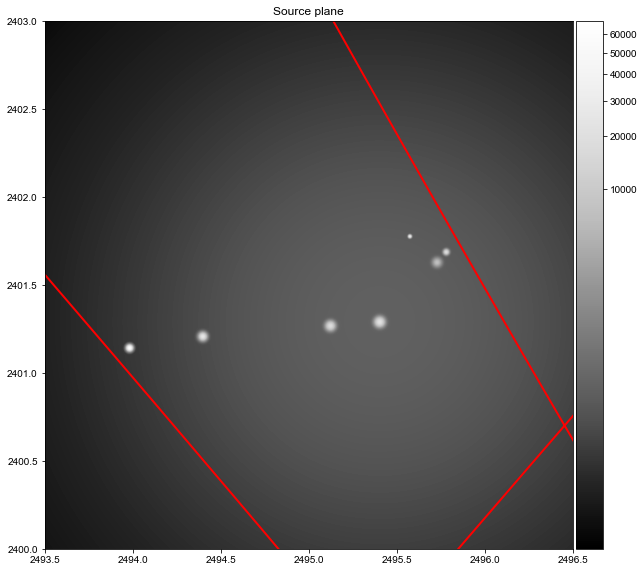

In [23]:
#theta = [np.median(samples2[:,0]), np.median(samples2[:,1]), 
#         np.median(samples2[:,2]), np.median(samples2[:,3]),
#        #np.median(samples[:,0]), np.median(samples[:,1])]
#         amp3, r3, amp4, r4, amp5, r5, amp6, r6, amp7, r7, amp8, r8]
         #0.9, 0.02, 0.9, 0.02, 0.9, 0.02,#]
         #0.9, 0.02, 0.9, 0.02, 0.9, 0.02]
#theta = [1., 0.02, 1., 0.02, 1., 0.02, 1., 0.02, 1., 0.02, 1., 0.02, 1., 0.02, 1., 0.02]
print(theta)

#xlo, xhi = 2551, 2556
#ylo, yhi = 2455, 2460

#Lenstool source plane
#xlo, xhi = 2529, 2534
#ylo, yhi = 2389, 2394

#LTM source plane
#xlo, xhi = 2493, 2498
xlo, xhi = 2493.5, 2496.5
ylo, yhi = 2400, 2403
#ylo, yhi = 2399, 2404

nnxx = np.linspace(xlo, xhi, 1000) 
nnyy = np.linspace(ylo, yhi, 1000) 
xxx, yyy = np.meshgrid(nnxx, nnyy)

amp1, reff1, amp2, reff2, amp3, reff3, amp4, reff4, amp5, reff5, amp6, reff6, amp7, reff7, amp8, reff8 = theta
#amp6 *= 10
#amp7 *= 10
#amp8 *= 10
#reff7 *= 100

gauss1 = Gaussian2D(amp1, x_mean=xs1, y_mean=ys1, x_stddev=reff1, y_stddev=reff1) #bright knot
gauss2 = Gaussian2D(amp2, x_mean=xs2, y_mean=ys2, x_stddev=reff2, y_stddev=reff2) #diffuse
gauss3 = Gaussian2D(amp3, x_mean=xs2, y_mean=ys2, x_stddev=reff3, y_stddev=reff3) #central knot
gauss4 = Gaussian2D(amp4, x_mean=xs3, y_mean=ys3, x_stddev=reff4, y_stddev=reff4) #small iso
gauss5 = Gaussian2D(amp5, x_mean=xs4, y_mean=ys4, x_stddev=reff5, y_stddev=reff5) #small central
gauss6 = Gaussian2D(amp6, x_mean=xs5, y_mean=ys5, x_stddev=reff6, y_stddev=reff6) #5
gauss7 = Gaussian2D(amp7, x_mean=xs6, y_mean=ys6, x_stddev=reff7, y_stddev=reff7) #6
gauss8 = Gaussian2D(amp8, x_mean=xs7, y_mean=ys7, x_stddev=reff8, y_stddev=reff8) #7
#gauss9 = Gaussian2D(2., x_mean=xs8, y_mean=ys8, x_stddev=0.01, y_stddev=0.01) # star
#gauss10 = Gaussian2D(2., x_mean=xs9, y_mean=ys9, x_stddev=0.01, y_stddev=0.01) # X

combined = gauss1 + gauss2 + gauss3 + gauss4 + gauss5 + gauss6 + gauss7 + gauss8

source_show = combined(xxx, yyy)
print(source_show.shape)

#scale = pc_to_pix(100., 6.2)
#scaleplot = scale 

norm = ImageNormalize(stretch=PowerStretch(a=.2))

fig, ax1 = plt.subplots(figsize=(10,10))


im1 = ax1.imshow(source_show, origin='lower', cmap='Greys_r', 
                 norm=norm, extent=[xlo, xhi, ylo, yhi])

div1 = make_axes_locatable(ax1)
cax1 = div1.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax1, orientation='vertical')
ax1.set_title('Source plane')
#scalebar = AnchoredSizeBar(ax1.transData,
#                           scaleplot, '100 pc', 'lower left', 
#                           pad=0.1,
#                           color='white',
#                           frameon=False,
#                           size_vertical=.03)

#ax1.add_artist(scalebar)

ixx = [(caustic_x >= xlo-1) & (caustic_x <= xhi+1) & (caustic_y >= ylo-1) & (caustic_y <= yhi+1)]

#ax1.plot(caustic_x[ixx], caustic_y[ixx], 'r-')
ax1.contour(xss, yss, magnifinv, [0], colors='r', linewidths=2)
#ax1.plot(xs3, ys3, 'yo', fillstyle='none')

ax1.set_xlim(xlo, xhi)
ax1.set_ylim(ylo, yhi)

#plt.savefig('whl0137/sourceplane_nocc_AAS21.png', dpi=300, facecolor='w', bbox_inches='tight')

plt.show()

In [21]:
print("R_diffuse = %.2f pc" %(pix_to_pc(reff2, 6.2)))
d_pix = np.sqrt((xs1 - xs2)**2 + (ys1-ys2)**2)
print("Dist = %.2f pc" %(pix_to_pc(d_pix, 6.2)))
print("R_knot = %.2f pc" %(pix_to_pc(reff1, 6.2)))

NameError: name 'reff2' is not defined

In [2]:
indir = 'whl0137'
imfile = 'hlsp_relics_hst_wfc3ir-60mas_whl0137-08_f110w_drz.fits' 
imfile = os.path.join(indir,imfile)

imhdu = fits.open(imfile)
imdata = imhdu[0].data

modeldir1 = 'whl0137/lens_modelling/zitrin/TosendBrianWithMinimization/models/imv2_125only/final_f012_5kstep'
ax_ltm = fits.open(os.path.join(modeldir1, 'alpha_x_whl0137_6p2_20210206_LTM_Gc_2HST.fits'))[0].data
ay_ltm = fits.open(os.path.join(modeldir1, 'alpha_y_whl0137_6p2_20210206_LTM_Gc_2HST.fits'))[0].data

modeldir2 = 'whl0137/lens_modelling/lenstool/ModelQ/best'
ax_lenstool = fits.open(os.path.join(modeldir2, 'dx_z6p2_2HST.fits'))[0].data
ay_lenstool = fits.open(os.path.join(modeldir2, 'dy_z6p2_2HST.fits'))[0].data

modeldir3 = 'whl0137/lens_modelling/wslap'
ax_wslap = fits.open(os.path.join(modeldir3, 'AlphaX_Z_arcsec_ModelIIc_2HST.fits'))[0].data
ay_wslap = fits.open(os.path.join(modeldir3, 'AlphaY_Z_arcsec_ModelIIc_2HST.fits'))[0].data

modeldir4 = 'whl0137/lens_modelling/glafic/c_1'
ax_glafic = fits.open(os.path.join(modeldir4, 'hlsp_relics_model_model_whl0137-08_glafic_v3_x-arcsec-deflectz6p2_2HST.fits'))[0].data
ay_glafic = fits.open(os.path.join(modeldir4, 'hlsp_relics_model_model_whl0137-08_glafic_v3_y-arcsec-deflectz6p2_2HST.fits'))[0].data

In [3]:
# Define coordinate grid
yy, xx = np.indices(ax_ltm.shape)

In [10]:
#################################################################################
################## DEFINE PARAMS FOR LTM MODEL ##################################
#################################################################################

# Source position grid
xss = xx - ax_ltm
yss = yy - ay_ltm

xlo, xhi = 2700, 3100 #whl0137
ylo, yhi = 1800, 2100

# define galaxy model
model_ltm = kf.GalModel()

# add various clumps to galaxy model
x1, y1 = 2950, 1976
xs1 = x1 - ax_ltm[y1, x1]
ys1 = y1 - ay_ltm[y1, x1]
clump1_ltm = kf.Clump(x0=xs1, y0=ys1)
clump1_ltm.set_prior(amin=0, amax=500000, rmin=0, rmax=10)
model_ltm.add_clump(clump1_ltm)

x2, y2 = 2897, 1935
xs2 = x2 - ax_ltm[y2, x2]
ys2 = y2 - ay_ltm[y2, x2]
clump2_ltm = kf.Clump(x0=xs2, y0=ys2)
clump2_ltm.set_prior(amin=0, amax=500000, rmin=0, rmax=500)
model_ltm.add_clump(clump2_ltm)

if 1:
    #xlow0, ylow0 = 2860, 1900 # These are in pixel coordinates
    #xlow1, ylow1 = 2960, 1975
    xlow0, ylow0 = 2780, 1835
    xlow1, ylow1 = 3030, 2020
    length = int(np.hypot(xlow1-xlow0, ylow1-ylow0))
    xlow_cut, ylow_cut = np.linspace(xlow0, xlow1, length), np.linspace(ylow0, ylow1, length)

    #xhi0, yhi0 = 2860, 1915 # These are in pixel coordinates
    #xhi1, yhi1 = 2960, 1990
    xhi0, yhi0 = 2780, 1885
    xhi1, yhi1 = 3030, 2070
    length = int(np.hypot(xhi1-xhi0, yhi1-yhi0))
    xhi_cut, yhi_cut = np.linspace(xhi0, xhi1, length), np.linspace(yhi0, yhi1, length)

    mask = np.zeros(ax_ltm.shape, dtype=bool)
    for i in range(length):
        mask[ylow_cut[i].astype(np.int):yhi_cut[i].astype(np.int),xlow_cut[i].astype(np.int)] = True

    # define second region around small white galaxy to cut that out
    whitey_x, whitey_y = 2951, 2000
    wsize = 7 # pixels
    mask[whitey_y-wsize:whitey_y+wsize, whitey_x-wsize:whitey_x+wsize] = False
    imcopy = np.copy(imdata) 
    imcopy[~mask] = 0

    
xx_crop = xx[ylo:yhi,xlo:xhi]
yy_crop = yy[ylo:yhi,xlo:xhi]

ax_crop_ltm = ax_ltm[ylo:yhi,xlo:xhi]
ay_crop_ltm = ay_ltm[ylo:yhi,xlo:xhi]

xss_crop = xss[ylo:yhi,xlo:xhi]
yss_crop = yss[ylo:yhi,xlo:xhi]

# define extra parameters needed for model fitting

model_ltm.xss = xss_crop 
model_ltm.yss = yss_crop
model_ltm.xlo = xlo#2650
model_ltm.xhi = xhi#3100
model_ltm.ylo = ylo#1800
model_ltm.yhi = yhi#2100

model_ltm.arcim = imcopy[ylo:yhi, xlo:xhi] #arc, subtracted
model_ltm.simim = np.zeros_like(model_ltm.arcim)
model_ltm.resolution = 'mixed' # 'high', 'mixed', or 'standard'
model_ltm.super_res = False

star_positions = [(2231, 1622), # 1622
                  (2541, 3475), # 136
                  (2163, 2913), # 593
                  (3535, 1560), # 1677
                  (2864, 2477), # 898
                  (1724, 2667),] # 778

model_ltm.set_psf(style='list', star_imdata=imdata, pos_list=star_positions, extent=11)

rmsfile = 'hlsp_relics_hst_wfc3ir-60mas_whl0137-08_f110w_rms.fits'
rmsfile = os.path.join(indir, rmsfile)
model_ltm.set_sigma(rmsfile=rmsfile, exp_time=5123.501098)

if model_ltm.resolution == 'mixed':
    if 1:
        xlo_star, xhi_star = 2945, 2990
        ylo_star, yhi_star = 1970, 2015

        model_ltm.init_mixed_resolution(0.01, 
                                    xlo_star, xhi_star, 
                                    ylo_star, yhi_star, 
                                    xx_crop, yy_crop, 
                                    ax_crop_ltm, ay_crop_ltm)

        model_ltm.hires_im = imdata[ylo_star:yhi_star,xlo_star:xhi_star]

In [11]:
######################################################################################
################## DEFINE PARAMS FOR LENSTOOL MODEL ##################################
######################################################################################

# Source position grid
xss = xx - ax_lenstool
yss = yy - ay_lenstool

xlo, xhi = 2700, 3100 #whl0137
ylo, yhi = 1800, 2100

# define galaxy model
model_lenstool = kf.GalModel()

# add various clumps to galaxy model
x1, y1 = 2950, 1976
xs1 = x1 - ax_lenstool[y1, x1]
ys1 = y1 - ay_lenstool[y1, x1]
clump1_lenstool = kf.Clump(x0=xs1, y0=ys1)
clump1_lenstool.set_prior(amin=0, amax=500000, rmin=0, rmax=10)
model_lenstool.add_clump(clump1_lenstool)

x2, y2 = 2897, 1935
xs2 = x2 - ax_lenstool[y2, x2]
ys2 = y2 - ay_lenstool[y2, x2]
clump2_lenstool = kf.Clump(x0=xs2, y0=ys2)
clump2_lenstool.set_prior(amin=0, amax=500000, rmin=0, rmax=500)
model_lenstool.add_clump(clump2_lenstool)

if 1:
    #xlow0, ylow0 = 2860, 1900 # These are in pixel coordinates
    #xlow1, ylow1 = 2960, 1975
    xlow0, ylow0 = 2780, 1835
    xlow1, ylow1 = 3030, 2020
    length = int(np.hypot(xlow1-xlow0, ylow1-ylow0))
    xlow_cut, ylow_cut = np.linspace(xlow0, xlow1, length), np.linspace(ylow0, ylow1, length)

    #xhi0, yhi0 = 2860, 1915 # These are in pixel coordinates
    #xhi1, yhi1 = 2960, 1990
    xhi0, yhi0 = 2780, 1885
    xhi1, yhi1 = 3030, 2070
    length = int(np.hypot(xhi1-xhi0, yhi1-yhi0))
    xhi_cut, yhi_cut = np.linspace(xhi0, xhi1, length), np.linspace(yhi0, yhi1, length)

    mask = np.zeros(ax_lenstool.shape, dtype=bool)
    for i in range(length):
        mask[ylow_cut[i].astype(np.int):yhi_cut[i].astype(np.int),xlow_cut[i].astype(np.int)] = True

    # define second region around small white galaxy to cut that out
    whitey_x, whitey_y = 2951, 2000
    wsize = 7 # pixels
    mask[whitey_y-wsize:whitey_y+wsize, whitey_x-wsize:whitey_x+wsize] = False
    imcopy = np.copy(imdata) 
    imcopy[~mask] = 0

    
xx_crop = xx[ylo:yhi,xlo:xhi]
yy_crop = yy[ylo:yhi,xlo:xhi]

ax_crop_ltm = ax_lenstool[ylo:yhi,xlo:xhi]
ay_crop_ltm = ay_lenstool[ylo:yhi,xlo:xhi]

xss_crop = xss[ylo:yhi,xlo:xhi]
yss_crop = yss[ylo:yhi,xlo:xhi]

# define extra parameters needed for model fitting

model_lenstool.xss = xss_crop 
model_lenstool.yss = yss_crop
model_lenstool.xlo = xlo#2650
model_lenstool.xhi = xhi#3100
model_lenstool.ylo = ylo#1800
model_lenstool.yhi = yhi#2100

model_lenstool.arcim = imcopy[ylo:yhi, xlo:xhi] #arc, subtracted
model_lenstool.simim = np.zeros_like(model_lenstool.arcim)
model_lenstool.resolution = 'mixed' # 'high', 'mixed', or 'standard'
model_lenstool.super_res = False

star_positions = [(2231, 1622), # 1622
                  (2541, 3475), # 136
                  (2163, 2913), # 593
                  (3535, 1560), # 1677
                  (2864, 2477), # 898
                  (1724, 2667),] # 778

model_lenstool.set_psf(style='list', star_imdata=imdata, pos_list=star_positions, extent=11)

rmsfile = 'hlsp_relics_hst_wfc3ir-60mas_whl0137-08_f110w_rms.fits'
rmsfile = os.path.join(indir, rmsfile)
model_lenstool.set_sigma(rmsfile=rmsfile, exp_time=5123.501098)

if model_lenstool.resolution == 'mixed':
    if 1:
        xlo_star, xhi_star = 2945, 2990
        ylo_star, yhi_star = 1970, 2015

        model_lenstool.init_mixed_resolution(0.01, 
                                    xlo_star, xhi_star, 
                                    ylo_star, yhi_star, 
                                    xx_crop, yy_crop, 
                                    ax_crop_ltm, ay_crop_ltm)

        model_lenstool.hires_im = imdata[ylo_star:yhi_star,xlo_star:xhi_star]

In [16]:
####################################################################################
################## DEFINE PARAMS FOR GLAFIC MODEL ##################################
####################################################################################

# Source position grid
xss = xx - ax_glafic
yss = yy - ay_glafic

xlo, xhi = 2600, 3100 #whl0137
ylo, yhi = 1800, 2100

# define galaxy model
model_glafic = kf.GalModel()

# add various clumps to galaxy model
x1, y1 = 2950, 1976
xs1 = x1 - ax_glafic[y1, x1]
ys1 = y1 - ay_glafic[y1, x1]
clump1_glafic = kf.Clump(x0=xs1, y0=ys1)
clump1_glafic.set_prior(amin=0, amax=500000, rmin=0, rmax=10)
model_glafic.add_clump(clump1_glafic)

x2, y2 = 2897, 1935
xs2 = x2 - ax_glafic[y2, x2]
ys2 = y2 - ay_glafic[y2, x2]
clump2_glafic = kf.Clump(x0=xs2, y0=ys2)
clump2_glafic.set_prior(amin=0, amax=500000, rmin=0, rmax=500)
model_glafic.add_clump(clump2_glafic)

if 1:
    #xlow0, ylow0 = 2860, 1900 # These are in pixel coordinates
    #xlow1, ylow1 = 2960, 1975
    xlow0, ylow0 = 2780, 1835
    xlow1, ylow1 = 3030, 2020
    length = int(np.hypot(xlow1-xlow0, ylow1-ylow0))
    xlow_cut, ylow_cut = np.linspace(xlow0, xlow1, length), np.linspace(ylow0, ylow1, length)

    #xhi0, yhi0 = 2860, 1915 # These are in pixel coordinates
    #xhi1, yhi1 = 2960, 1990
    xhi0, yhi0 = 2780, 1885
    xhi1, yhi1 = 3030, 2070
    length = int(np.hypot(xhi1-xhi0, yhi1-yhi0))
    xhi_cut, yhi_cut = np.linspace(xhi0, xhi1, length), np.linspace(yhi0, yhi1, length)

    mask = np.zeros(ax_glafic.shape, dtype=bool)
    for i in range(length):
        mask[ylow_cut[i].astype(np.int):yhi_cut[i].astype(np.int),xlow_cut[i].astype(np.int)] = True

    # define second region around small white galaxy to cut that out
    whitey_x, whitey_y = 2951, 2000
    wsize = 7 # pixels
    mask[whitey_y-wsize:whitey_y+wsize, whitey_x-wsize:whitey_x+wsize] = False
    imcopy = np.copy(imdata) 
    imcopy[~mask] = 0

    
xx_crop = xx[ylo:yhi,xlo:xhi]
yy_crop = yy[ylo:yhi,xlo:xhi]

ax_crop_glafic = ax_glafic[ylo:yhi,xlo:xhi]
ay_crop_glafic = ay_glafic[ylo:yhi,xlo:xhi]

xss_crop = xss[ylo:yhi,xlo:xhi]
yss_crop = yss[ylo:yhi,xlo:xhi]

# define extra parameters needed for model fitting

model_glafic.xss = xss_crop 
model_glafic.yss = yss_crop
model_glafic.xlo = xlo#2650
model_glafic.xhi = xhi#3100
model_glafic.ylo = ylo#1800
model_glafic.yhi = yhi#2100

model_glafic.arcim = imcopy[ylo:yhi, xlo:xhi] #arc, subtracted
model_glafic.simim = np.zeros_like(model_glafic.arcim)
model_glafic.resolution = 'mixed' # 'high', 'mixed', or 'standard'
model_glafic.super_res = False

star_positions = [(2231, 1622), # 1622
                  (2541, 3475), # 136
                  (2163, 2913), # 593
                  (3535, 1560), # 1677
                  (2864, 2477), # 898
                  (1724, 2667),] # 778

model_glafic.set_psf(style='list', star_imdata=imdata, pos_list=star_positions, extent=11)

rmsfile = 'hlsp_relics_hst_wfc3ir-60mas_whl0137-08_f110w_rms.fits'
rmsfile = os.path.join(indir, rmsfile)
model_glafic.set_sigma(rmsfile=rmsfile, exp_time=5123.501098)

if model_glafic.resolution == 'mixed':
    if 1:
        xlo_star, xhi_star = 2945, 2990
        ylo_star, yhi_star = 1970, 2015

        model_glafic.init_mixed_resolution(0.01, 
                                    xlo_star, xhi_star, 
                                    ylo_star, yhi_star, 
                                    xx_crop, yy_crop, 
                                    ax_crop_ltm, ay_crop_ltm)

        model_glafic.hires_im = imdata[ylo_star:yhi_star,xlo_star:xhi_star]

In [13]:
###################################################################################
################## DEFINE PARAMS FOR WSLAP MODEL ##################################
###################################################################################

# Source position grid
xss = xx - ax_wslap
yss = yy - ay_wslap

xlo, xhi = 2700, 3100 #whl0137
ylo, yhi = 1800, 2100

# define galaxy model
model_wslap = kf.GalModel()

# add various clumps to galaxy model
x1, y1 = 2950, 1976
xs1 = x1 - ax_wslap[y1, x1]
ys1 = y1 - ay_wslap[y1, x1]
clump1_wslap = kf.Clump(x0=xs1, y0=ys1)
clump1_wslap.set_prior(amin=0, amax=500000, rmin=0, rmax=10)
model_wslap.add_clump(clump1_wslap)

x2, y2 = 2897, 1935
xs2 = x2 - ax_wslap[y2, x2]
ys2 = y2 - ay_wslap[y2, x2]
clump2_wslap = kf.Clump(x0=xs2, y0=ys2)
clump2_wslap.set_prior(amin=0, amax=500000, rmin=0, rmax=500)
model_wslap.add_clump(clump2_wslap)

if 1:
    #xlow0, ylow0 = 2860, 1900 # These are in pixel coordinates
    #xlow1, ylow1 = 2960, 1975
    xlow0, ylow0 = 2780, 1835
    xlow1, ylow1 = 3030, 2020
    length = int(np.hypot(xlow1-xlow0, ylow1-ylow0))
    xlow_cut, ylow_cut = np.linspace(xlow0, xlow1, length), np.linspace(ylow0, ylow1, length)

    #xhi0, yhi0 = 2860, 1915 # These are in pixel coordinates
    #xhi1, yhi1 = 2960, 1990
    xhi0, yhi0 = 2780, 1885
    xhi1, yhi1 = 3030, 2070
    length = int(np.hypot(xhi1-xhi0, yhi1-yhi0))
    xhi_cut, yhi_cut = np.linspace(xhi0, xhi1, length), np.linspace(yhi0, yhi1, length)

    mask = np.zeros(ax_wslap.shape, dtype=bool)
    for i in range(length):
        mask[ylow_cut[i].astype(np.int):yhi_cut[i].astype(np.int),xlow_cut[i].astype(np.int)] = True

    # define second region around small white galaxy to cut that out
    whitey_x, whitey_y = 2951, 2000
    wsize = 7 # pixels
    mask[whitey_y-wsize:whitey_y+wsize, whitey_x-wsize:whitey_x+wsize] = False
    imcopy = np.copy(imdata) 
    imcopy[~mask] = 0

    
xx_crop = xx[ylo:yhi,xlo:xhi]
yy_crop = yy[ylo:yhi,xlo:xhi]

ax_crop_wslap = ax_wslap[ylo:yhi,xlo:xhi]
ay_crop_wslap = ay_wslap[ylo:yhi,xlo:xhi]

xss_crop = xss[ylo:yhi,xlo:xhi]
yss_crop = yss[ylo:yhi,xlo:xhi]

# define extra parameters needed for model fitting

model_wslap.xss = xss_crop 
model_wslap.yss = yss_crop
model_wslap.xlo = xlo#2650
model_wslap.xhi = xhi#3100
model_wslap.ylo = ylo#1800
model_wslap.yhi = yhi#2100

model_wslap.arcim = imcopy[ylo:yhi, xlo:xhi] #arc, subtracted
model_wslap.simim = np.zeros_like(model_wslap.arcim)
model_wslap.resolution = 'mixed' # 'high', 'mixed', or 'standard'
model_wslap.super_res = False

star_positions = [(2231, 1622), # 1622
                  (2541, 3475), # 136
                  (2163, 2913), # 593
                  (3535, 1560), # 1677
                  (2864, 2477), # 898
                  (1724, 2667),] # 778

model_wslap.set_psf(style='list', star_imdata=imdata, pos_list=star_positions, extent=11)

rmsfile = 'hlsp_relics_hst_wfc3ir-60mas_whl0137-08_f110w_rms.fits'
rmsfile = os.path.join(indir, rmsfile)
model_wslap.set_sigma(rmsfile=rmsfile, exp_time=5123.501098)

if model_wslap.resolution == 'mixed':
    if 1:
        xlo_star, xhi_star = 2945, 2990
        ylo_star, yhi_star = 1970, 2015

        model_wslap.init_mixed_resolution(0.01, 
                                    xlo_star, xhi_star, 
                                    ylo_star, yhi_star, 
                                    xx_crop, yy_crop, 
                                    ax_crop_ltm, ay_crop_ltm)

        model_wslap.hires_im = imdata[ylo_star:yhi_star,xlo_star:xhi_star]

In [17]:
mcmc_arc = 'whl0137/knots/knotfit_chains/knot_arc_mixedres_500step.h5'
mcmc_star = 'whl0137/knots/knotfit_chains/star/prefit_3kstep.h5'
arc_reader = emcee.backends.HDFBackend(mcmc_arc)
arc_samples = arc_reader.get_chain(discard=100,flat=True)
star_reader = emcee.backends.HDFBackend(mcmc_star)
star_samples = star_reader.get_chain(discard=100,flat=True)

r_star = np.median(star_samples[:,0])
amp_star = np.median(star_samples[:,1])
r_knot = np.median(arc_samples[:,0])
amp_knot = np.median(arc_samples[:,1])
r_arc = np.median(arc_samples[:,2])
amp_arc = np.median(arc_samples[:,3])

theta_ltm = [r_knot, amp_knot, r_arc, amp_arc]#, r_star, amp_star]


cv_ltm = model_ltm.convolved(theta_ltm)
arcimage_ltm = np.copy(model_ltm.arcim)
simimage_ltm =  np.zeros_like(arcimage_ltm) # np.copy(model.simim) # 

simimage_ltm[:,:] += cv_ltm[:,:]

xoffset = 50
#yoffset = -10
arcimage_ltm[:,xoffset:] += cv_ltm[:,:-xoffset]


#######################################
theta_lenstool = [r_knot, amp_knot*2, r_arc, amp_arc]

cv_lenstool = model_lenstool.convolved(theta_lenstool)
arcimage_lenstool = np.copy(model_lenstool.arcim)
simimage_lenstool =  np.zeros_like(arcimage_lenstool) # np.copy(model.simim) # 

simimage_lenstool[:,:] += cv_lenstool[:,:]

xoffset = 50
#yoffset = -10
arcimage_lenstool[:,xoffset:] += cv_lenstool[:,:-xoffset]


####################################
theta_glafic = [r_knot, amp_knot*8, r_arc, amp_arc]

cv_glafic = model_glafic.convolved(theta_glafic)
arcimage_glafic = np.copy(model_glafic.arcim)
simimage_glafic =  np.zeros_like(arcimage_glafic) # np.copy(model.simim) # 

simimage_glafic[:,:] += cv_glafic[:,:]

xoffset = 50
#yoffset = -10
arcimage_glafic[:,xoffset:] += cv_glafic[:,:-xoffset]


##########################################
theta_wslap = [r_knot, amp_knot*55, r_arc, amp_arc*3]

cv_wslap = model_wslap.convolved(theta_wslap)
arcimage_wslap = np.copy(model_wslap.arcim)
simimage_wslap =  np.zeros_like(arcimage_wslap) # np.copy(model.simim) # 

simimage_wslap[:,:] += cv_wslap[:,:]

xoffset = 50
#yoffset = -10
arcimage_wslap[:,xoffset:] += cv_wslap[:,:-xoffset]

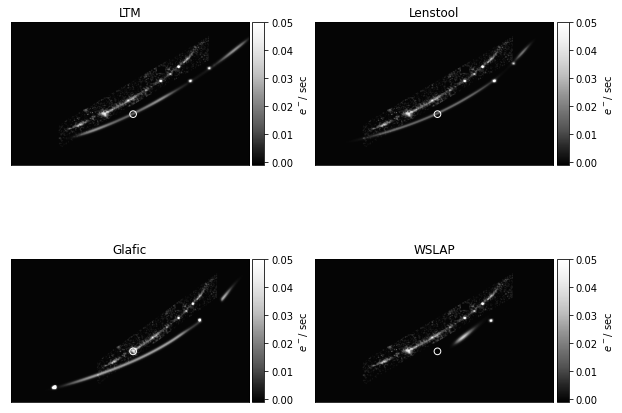

In [18]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(10,8))


im1 = ax1.imshow(arcimage_ltm, 
                 origin='lower', cmap='Greys_r', 
                 extent=(xlo,xhi,ylo,yhi),
                 vmin=-0.001, vmax=0.05)#, norm=norm)#)##)

div1 = make_axes_locatable(ax1)
cax1 = div1.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im1, cax=cax1, orientation='vertical')
cbar.set_label('$e^-$/ sec')
#ax1.set_title('HST F110W')
ax1.set_xticks([])
ax1.set_yticks([])
circle = plt.Circle((2857, 1907), 7, color='white', fill=False)
ax1.add_artist(circle)
#ax1.text(2857-70, 1907,"Interloper", color='white')
ax1.set_title('LTM')


im2 = ax2.imshow(arcimage_lenstool, 
                 origin='lower', cmap='Greys_r', 
                 extent=(xlo,xhi,ylo,yhi),
                 vmin=-0.001, vmax=0.05)#, norm=norm)#)##)

div2 = make_axes_locatable(ax2)
cax2 = div2.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im1, cax=cax2, orientation='vertical')
cbar.set_label('$e^-$/ sec')
#ax1.set_title('HST F110W')
ax2.set_xticks([])
ax2.set_yticks([])
circle = plt.Circle((2857, 1907), 7, color='white', fill=False)
ax2.add_artist(circle)
#ax2.text(2857-70, 1907,"Interloper", color='white')
ax2.set_title('Lenstool')


im3 = ax3.imshow(arcimage_glafic, 
                 origin='lower', cmap='Greys_r', 
                 extent=(xlo,xhi,ylo,yhi),
                 vmin=-0.001, vmax=0.05)#, norm=norm)#)##)

div3 = make_axes_locatable(ax3)
cax3 = div3.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im3, cax=cax3, orientation='vertical')
cbar.set_label('$e^-$/ sec')
#ax1.set_title('HST F110W')
ax3.set_xticks([])
ax3.set_yticks([])
circle = plt.Circle((2857, 1907), 7, color='white', fill=False)
ax3.add_artist(circle)
#ax3.text(2857-70, 1907,"Interloper", color='white')
ax3.set_title('Glafic')


im4 = ax4.imshow(arcimage_wslap, 
                 origin='lower', cmap='Greys_r', 
                 extent=(xlo,xhi,ylo,yhi),
                 vmin=-0.001, vmax=0.05)#, norm=norm)#)##)

div4 = make_axes_locatable(ax4)
cax4 = div4.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im4, cax=cax4, orientation='vertical')
cbar.set_label('$e^-$/ sec')
#ax1.set_title('HST F110W')
ax4.set_xticks([])
ax4.set_yticks([])
circle = plt.Circle((2857, 1907), 7, color='white', fill=False)
ax4.add_artist(circle)
#ax4.text(2857-70, 1907,"Interloper", color='white')
ax4.set_title('WSLAP')

plt.show()